In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy.fft as fft

In [28]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)
global_counter = 0

cpu


In [29]:
num_frames = 100

num_alphas = 10
alphlowlim = 0.0
alphhighlim = 0.9
num_ds = 50
dlowlim = 0.0
dhighlim = 4.9

In [30]:
alpha_vals = np.linspace(alphlowlim, alphhighlim, num_alphas)
print(alpha_vals)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value

d_vals = np.linspace(dlowlim, dhighlim, num_ds)
d_vals[0] = 1e-10 # set d=0 to a small value
# d_vals = np.ones(num_ds)*2.0
print(d_vals)

s_vals = np.linspace(0.2, 20.0, 101)
s_vals = s_vals[:-1]

r_vals = np.linspace(0.0, 10.0, 501)
r_vals = r_vals[:-1]
r_vals[0] = 1e-10 # set r=0 to a small value

# # k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
# # k_vals = fft.fftshift(k_vals)
# dk = 1/(r_vals[-1]-r_vals[0])
# # we need only the positive k values
# k_vals = np.linspace(0.0, np.pi*dk, (r_vals.shape[0]))
# # k_vals = np.linspace(-np.pi*dk, np.pi*dk, (r_vals.shape[0]))
# # k_vals = np.linspace(-np.pi/dk, np.pi/dk, r_vals.shape[0])
# # print(k_vals)
# print(k_vals.shape)

# convert to tensor
r_vals = torch.from_numpy(r_vals).float().to(device)


# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.0e-10 1.0e-01 2.0e-01 3.0e-01 4.0e-01 5.0e-01 6.0e-01 7.0e-01 8.0e-01
 9.0e-01 1.0e+00 1.1e+00 1.2e+00 1.3e+00 1.4e+00 1.5e+00 1.6e+00 1.7e+00
 1.8e+00 1.9e+00 2.0e+00 2.1e+00 2.2e+00 2.3e+00 2.4e+00 2.5e+00 2.6e+00
 2.7e+00 2.8e+00 2.9e+00 3.0e+00 3.1e+00 3.2e+00 3.3e+00 3.4e+00 3.5e+00
 3.6e+00 3.7e+00 3.8e+00 3.9e+00 4.0e+00 4.1e+00 4.2e+00 4.3e+00 4.4e+00
 4.5e+00 4.6e+00 4.7e+00 4.8e+00 4.9e+00]
shape of alpha_vals : (10,)
shape of d_vals : (50,)


In [31]:
# initial guess for P_alpha_d
P_alpha_d = np.zeros((s_vals.shape[0], num_alphas, num_ds))
# for i in range(num_frames):
#     P_alpha_d[i, 0, 0] = 1.0


alpha0 = 0.7
d0 = 2.0
for i in range(num_alphas):
    for j in range(num_ds):
        P_alpha_d[:, i, j] = np.exp(-((alpha_vals[i] - alpha0)**2 + (d_vals[j] - d0)**2) / 0.1)

# # normalize P_alpha_d
P_alpha_d = P_alpha_d / np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]
# P_alpha_d = P_alpha_d / np.sum(P_alpha_d, axis=(1, 2))[:, None, None]


# convert to tensor
alpha_vals = torch.from_numpy(alpha_vals).float().to(device)
# convert to tensor
d_vals = torch.from_numpy(d_vals).float().to(device)
# convert to tensor
# k_vals = torch.from_numpy(k_vals).float().to(device)

# convert P_alpha_d to torch tensor
P_alpha_d = torch.tensor(P_alpha_d, dtype=torch.float32, device=device, requires_grad=True)
# restrict P_alpha_d to be positive while training
# P_alpha_d = torch.clamp(P_alpha_d, min=0.0)
# print(P_alpha_d)

In [32]:
def contour_plt(P_alpha_d, i=0):
    """
    Visualise P_alpha_d as a countour plot using contourf
    """
    # plot
    # rescale the y axis to be in the range of 0 to 2
    # rescale the x axis to be in the range of 0 to 1000
    # check if P_alpha_d is a torch tensor
    if isinstance(P_alpha_d, torch.Tensor):
        P_alpha_d_copy = P_alpha_d.detach().cpu().numpy()
    else:
        P_alpha_d_copy = P_alpha_d.copy()
    plt.figure(figsize=(4, 4))
    x = np.linspace(dlowlim, dhighlim, num_ds)
    y = np.linspace(alphlowlim, alphhighlim, num_alphas)
    plt.contourf(x, y, P_alpha_d_copy[i], 20, cmap='RdGy')
    plt.xlabel('d')
    plt.ylabel('alpha')
    plt.colorbar()
    plt.show()

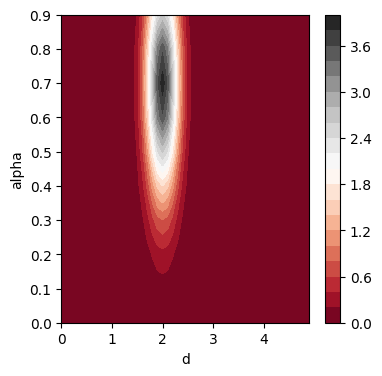

In [33]:
# # visualize P_alpha_d inital in subplots
# for i in range(num_frames):
#     contour_plt(P_alpha_d, i)
contour_plt(P_alpha_d, (s_vals.shape[0]//2))

In [34]:
# load u_pred
u = np.loadtxt("u.txt")
print(f"shape of u : {u.shape}")
# print(u_pred)
# convert to torch tensor
u = torch.tensor(u, dtype=torch.float32, device=device)
print(f"shape of u : {u.shape}")

shape of u : (100, 500)
shape of u : torch.Size([100, 500])


In [35]:
# load Z
Z = np.load("Z.npy")
print(f"shape of Z : {Z.shape}")
# convert Z to torch tensor
Z = torch.from_numpy(Z).float().to(device)
# print shape of Z
print(f"shape of Z : {Z.shape}")
# print(Z)
######################## check ########################
# normalize Z to have integral of Z over r equal to 1
# Z = Z / np.sum(Z * (r_vals[1]-r_vals[0]))
# print(Z)

shape of Z : (100, 500, 10, 50)
shape of Z : torch.Size([100, 500, 10, 50])


In [36]:
def give_u_pred(P_alpha_d, Z, alpha_vals, d_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = torch.zeros((s_vals.shape[0], len(r_vals)))
    # move u_pred to device
    u_pred = u_pred.to(device)

    # unvectorized version
    # for i in range(u_pred.shape[0]):
    #     for j in range(u_pred.shape[1]):
    #         integrand = torch.trapz(P_alpha_d[i] * Z[i, j, :, :], d_vals)
    #         u_pred[i, j] = torch.trapz(integrand, alpha_vals)
    # unvectorized version

    # vectorized version
    u_pred = torch.trapz(torch.trapz(P_alpha_d[:, None, :, :] * Z, d_vals, dim=3), alpha_vals, dim=2)
    # vectorized version

    
    ######################## check ########################
    # normalize u_pred
    # u_pred = u_pred / (u_pred.sum(dim=1, keepdim=True) + 1e-9)
    # u_pred = u_pred / (torch.trapz(u_pred, k_vals, dim=1, keepdim=True))
    # norm = torch.trapz(u_pred, k_vals, dim=1)
    # u_pred = u_pred / norm[:, None]
    # u_pred = u_pred / np.trapz(u_pred, k_vals, axis=1).reshape(-1, 1)
    
    norm = (torch.trapz(u_pred, r_vals, dim=1))

    u_pred = u_pred / norm[:, None]


    return u_pred    

In [37]:
# manual loss function
def loss_function(P_alpha_d, u, Z, alpha_vals, d_vals, global_counter):
    # clamp P_alpha_d to be positive
    # P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)

    # normalize P_alpha_d
    norm = (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1))
    P_alpha_d = P_alpha_d / norm[:, None, None]


    # P_alpha_d = P_alpha_d / (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1, keepdim=True) + 1e-6)
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True))
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True) + 1e-6)
    # calculate u_pred using double integral
    u_pred = give_u_pred(P_alpha_d, Z, alpha_vals, d_vals)
    # calculate loss
    loss = torch.sum((u_pred - u)**2)
    # loss /= u.shape[0] * u.shape[1]
    # loss = torch.sum(abs(u_pred - u))
    # plot u_pred and u
    if(global_counter%5 == 0):
        plt.plot(u_pred.detach().cpu().numpy()[20], label='u_pred')
        plt.plot(u.detach().cpu().numpy()[20], label='u')
        plt.legend()
        plt.show()

    return loss

In [38]:
# write a function to train the model
def train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=100, lr=1e-1):
    # define the optimizer
    optimizer = torch.optim.Adam([P_alpha_d], lr=lr)
    # define the loss function
    loss_func = loss_function
    # define the loss history
    loss_history = []
    global_counter = 0
    # train the model
    for epoch in range(num_epochs):
        # calculate loss
        loss = loss_func(P_alpha_d, u, Z, alpha_vals, d_vals, global_counter)
        # zero the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update parameters
        optimizer.step()
        # append loss to loss history
        loss_history.append(loss.item())
        P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
        global_counter += 1
        # plot P_alpha_d
        if (epoch+1) % 5 == 0:
            contour_plt(P_alpha_d, (s_vals.shape[0]//2))
        # print loss
        if (epoch+1) % 1 == 0:
            print(f"epoch {epoch+1} / {num_epochs} : loss = {loss.item()}")
    # plot loss history
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return P_alpha_d

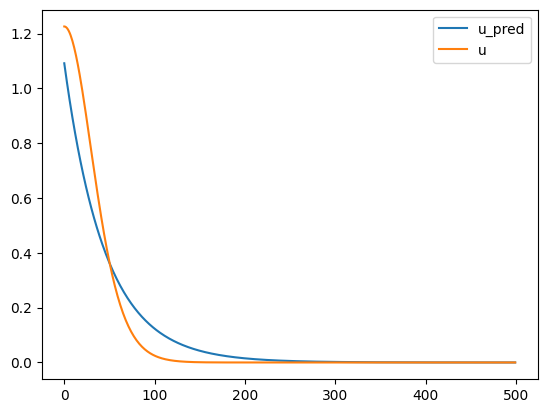

epoch 1 / 500 : loss = 256.5205383300781
epoch 2 / 500 : loss = 250.50222778320312
epoch 3 / 500 : loss = 245.16812133789062
epoch 4 / 500 : loss = 240.35379028320312


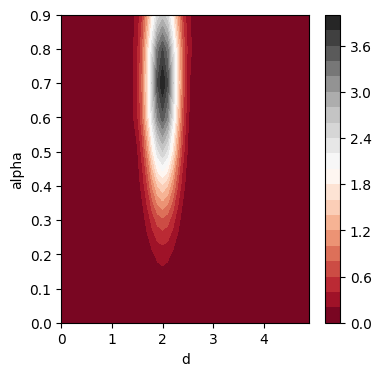

epoch 5 / 500 : loss = 235.93496704101562


epoch 6 / 500 : loss = 231.8290557861328
epoch 7 / 500 : loss = 227.99093627929688
epoch 8 / 500 : loss = 224.40992736816406
epoch 9 / 500 : loss = 221.13934326171875


epoch 10 / 500 : loss = 218.0652618408203


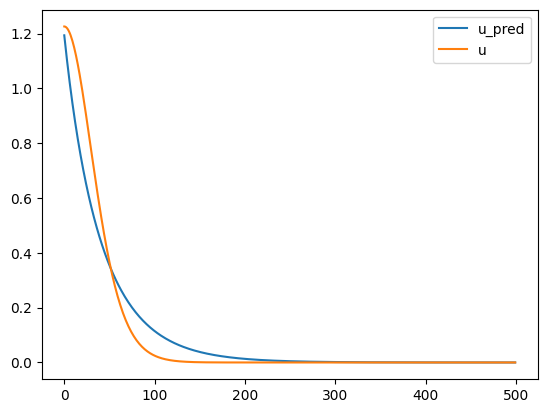

epoch 11 / 500 : loss = 215.17018127441406
epoch 12 / 500 : loss = 212.49151611328125
epoch 13 / 500 : loss = 209.98046875
epoch 14 / 500 : loss = 207.59683227539062


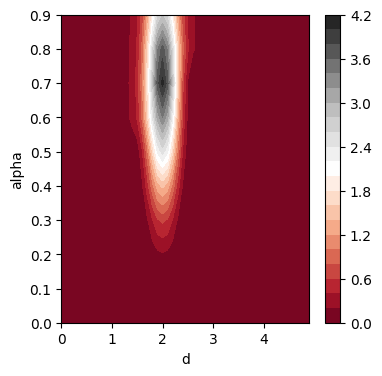

epoch 15 / 500 : loss = 205.37857055664062


epoch 16 / 500 : loss = 203.2891845703125
epoch 17 / 500 : loss = 201.2996368408203
epoch 18 / 500 : loss = 199.42193603515625
epoch 19 / 500 : loss = 197.64132690429688


epoch 20 / 500 : loss = 195.93975830078125


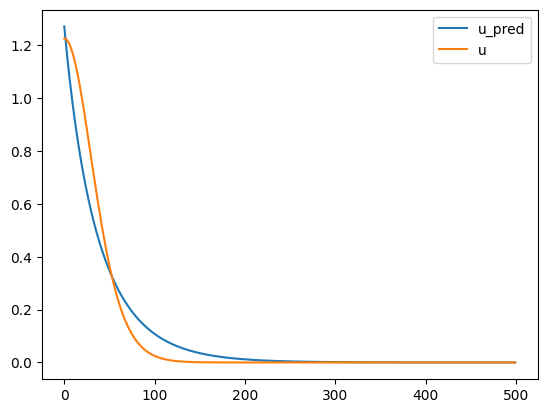

epoch 21 / 500 : loss = 194.31192016601562
epoch 22 / 500 : loss = 192.75302124023438
epoch 23 / 500 : loss = 191.26463317871094
epoch 24 / 500 : loss = 189.85508728027344


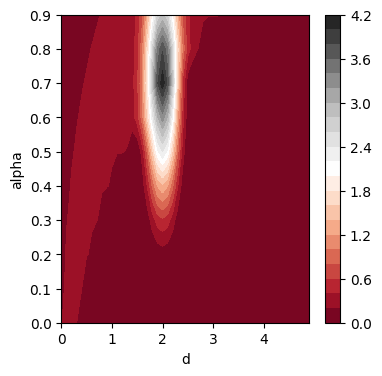

epoch 25 / 500 : loss = 188.5242156982422


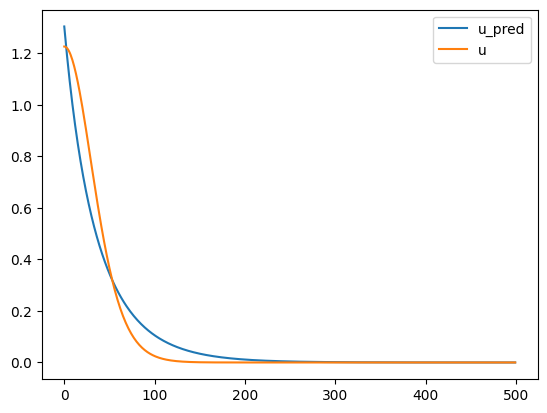

epoch 26 / 500 : loss = 187.2455596923828
epoch 27 / 500 : loss = 186.01513671875
epoch 28 / 500 : loss = 184.83038330078125
epoch 29 / 500 : loss = 183.6886749267578


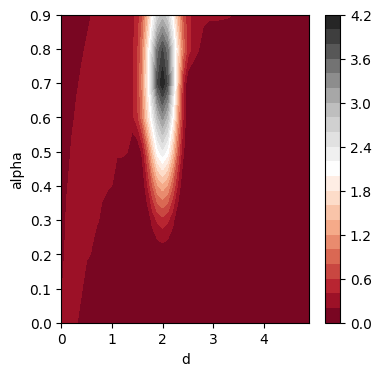

epoch 30 / 500 : loss = 182.59149169921875


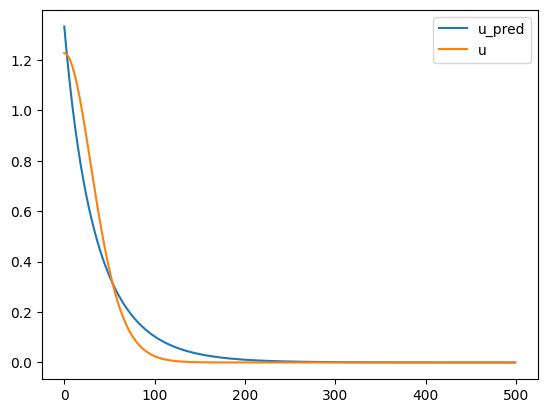

epoch 31 / 500 : loss = 181.53765869140625
epoch 32 / 500 : loss = 180.52749633789062
epoch 33 / 500 : loss = 179.56289672851562
epoch 34 / 500 : loss = 178.64996337890625


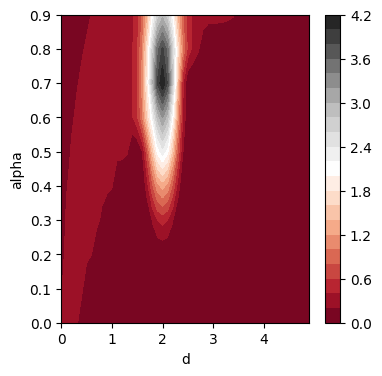

epoch 35 / 500 : loss = 177.775390625


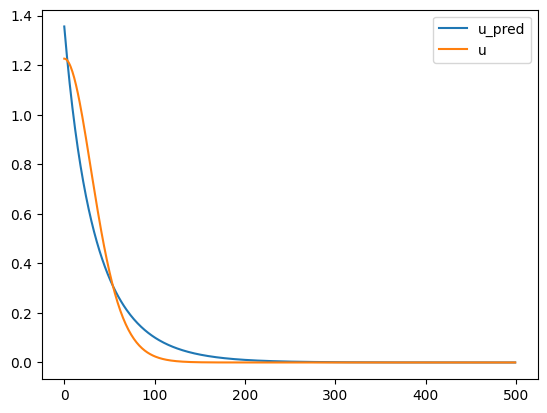

epoch 36 / 500 : loss = 176.93472290039062
epoch 37 / 500 : loss = 176.12838745117188
epoch 38 / 500 : loss = 175.36276245117188
epoch 39 / 500 : loss = 174.62493896484375


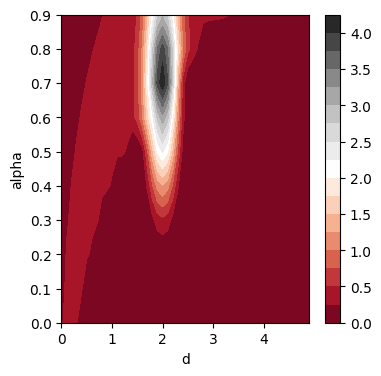

epoch 40 / 500 : loss = 173.90859985351562


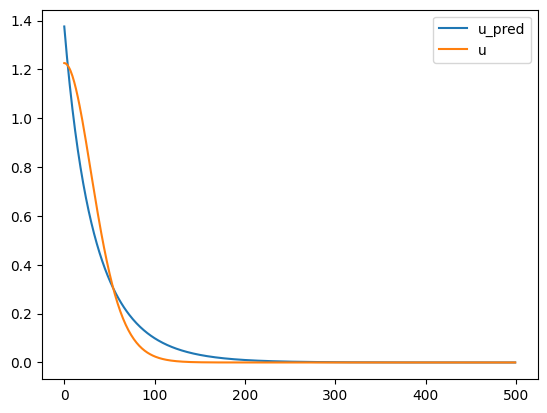

epoch 41 / 500 : loss = 173.2128143310547
epoch 42 / 500 : loss = 172.5369415283203
epoch 43 / 500 : loss = 171.87921142578125
epoch 44 / 500 : loss = 171.23965454101562


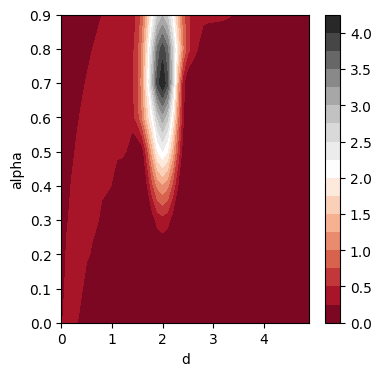

epoch 45 / 500 : loss = 170.6158447265625


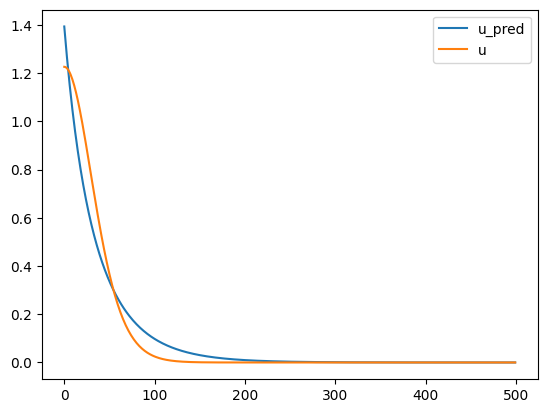

epoch 46 / 500 : loss = 170.00909423828125
epoch 47 / 500 : loss = 169.41693115234375
epoch 48 / 500 : loss = 168.83985900878906
epoch 49 / 500 : loss = 168.27670288085938


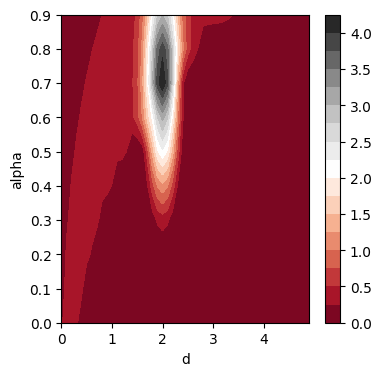

epoch 50 / 500 : loss = 167.72732543945312


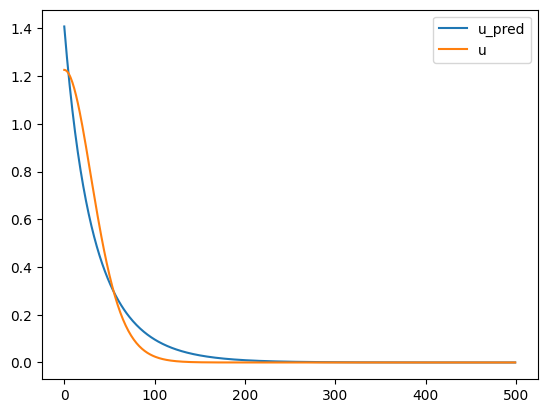

epoch 51 / 500 : loss = 167.19154357910156
epoch 52 / 500 : loss = 166.66897583007812
epoch 53 / 500 : loss = 166.15838623046875
epoch 54 / 500 : loss = 165.66061401367188


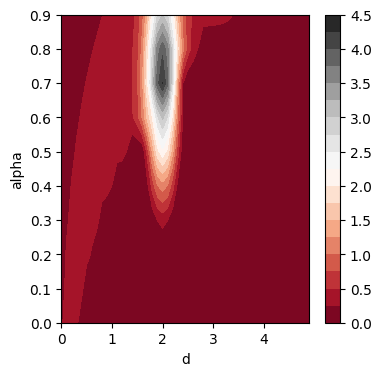

epoch 55 / 500 : loss = 165.174560546875


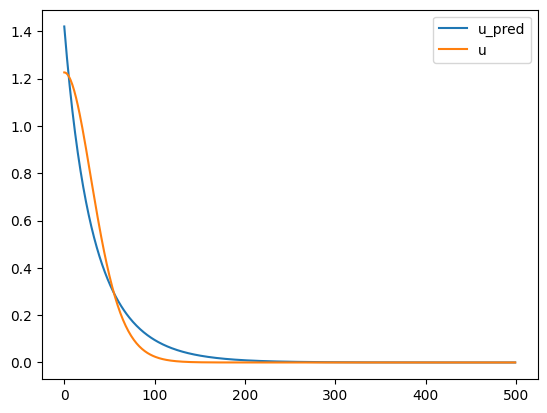

epoch 56 / 500 : loss = 164.69949340820312
epoch 57 / 500 : loss = 164.23550415039062
epoch 58 / 500 : loss = 163.78196716308594
epoch 59 / 500 : loss = 163.33837890625


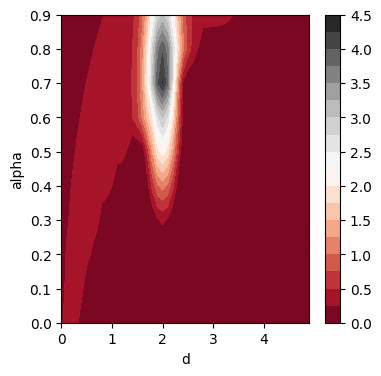

epoch 60 / 500 : loss = 162.90521240234375


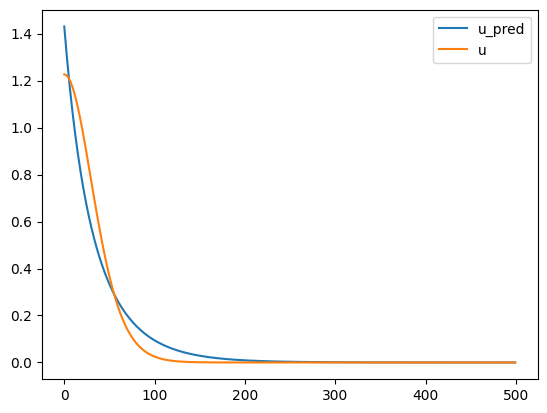

epoch 61 / 500 : loss = 162.48074340820312
epoch 62 / 500 : loss = 162.06546020507812
epoch 63 / 500 : loss = 161.66015625
epoch 64 / 500 : loss = 161.26315307617188


epoch 65 / 500 : loss = 160.8753204345703


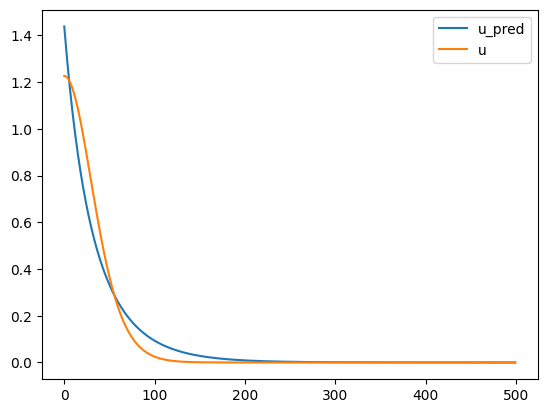

epoch 66 / 500 : loss = 160.50128173828125
epoch 67 / 500 : loss = 160.13876342773438
epoch 68 / 500 : loss = 159.78359985351562
epoch 69 / 500 : loss = 159.43679809570312


epoch 70 / 500 : loss = 159.09744262695312


epoch 71 / 500 : loss = 158.76426696777344
epoch 72 / 500 : loss = 158.4384002685547
epoch 73 / 500 : loss = 158.11912536621094
epoch 74 / 500 : loss = 157.80535888671875


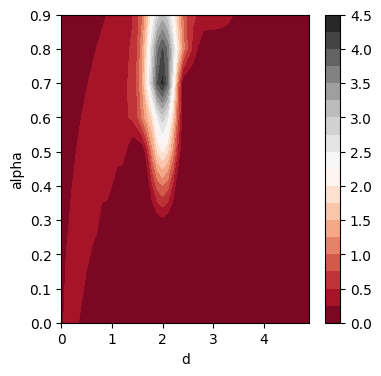

epoch 75 / 500 : loss = 157.4973602294922


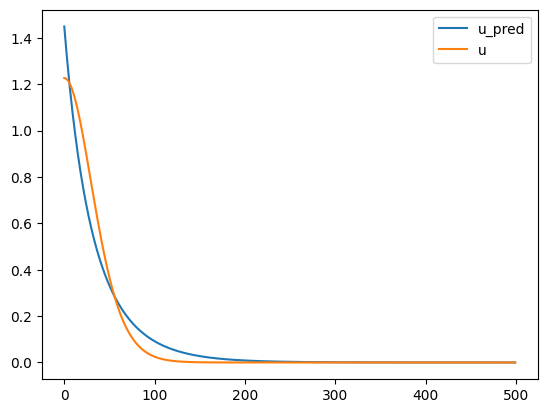

epoch 76 / 500 : loss = 157.19512939453125
epoch 77 / 500 : loss = 156.89813232421875
epoch 78 / 500 : loss = 156.6068878173828
epoch 79 / 500 : loss = 156.32107543945312


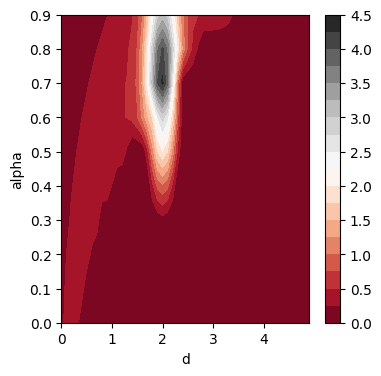

epoch 80 / 500 : loss = 156.0409698486328


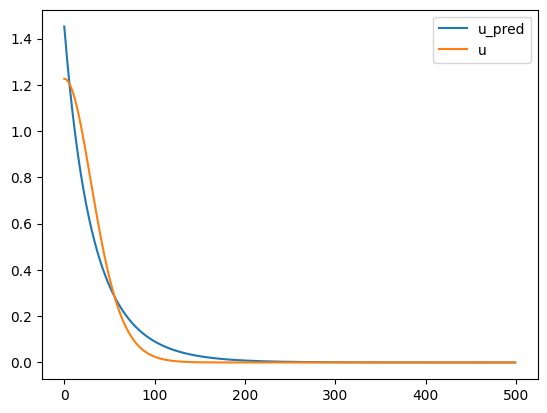

epoch 81 / 500 : loss = 155.76617431640625
epoch 82 / 500 : loss = 155.49661254882812
epoch 83 / 500 : loss = 155.23294067382812
epoch 84 / 500 : loss = 154.97592163085938


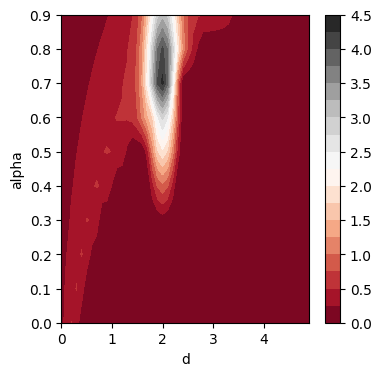

epoch 85 / 500 : loss = 154.72396850585938


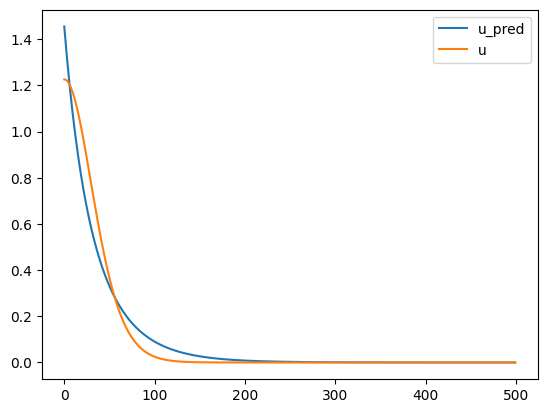

epoch 86 / 500 : loss = 154.47616577148438
epoch 87 / 500 : loss = 154.23248291015625
epoch 88 / 500 : loss = 153.993896484375
epoch 89 / 500 : loss = 153.7596435546875


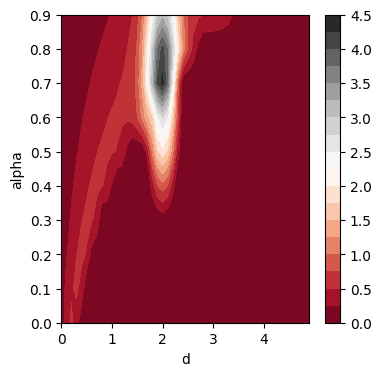

epoch 90 / 500 : loss = 153.5289764404297


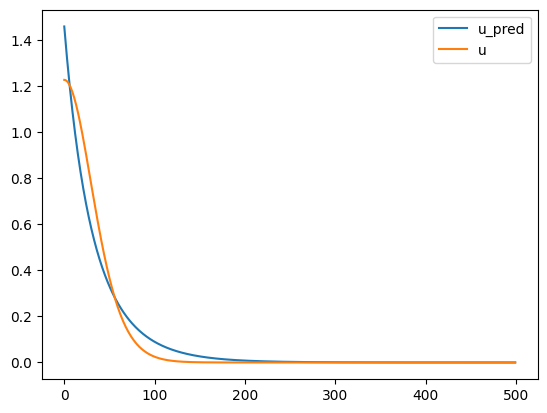

epoch 91 / 500 : loss = 153.30227661132812
epoch 92 / 500 : loss = 153.0823211669922
epoch 93 / 500 : loss = 152.87152099609375
epoch 94 / 500 : loss = 152.6639404296875


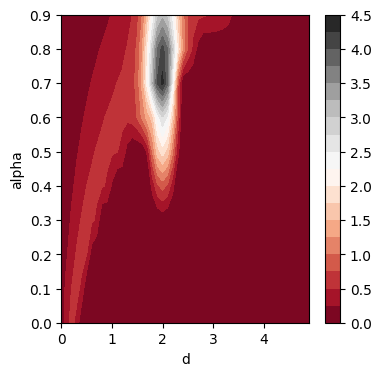

epoch 95 / 500 : loss = 152.45887756347656


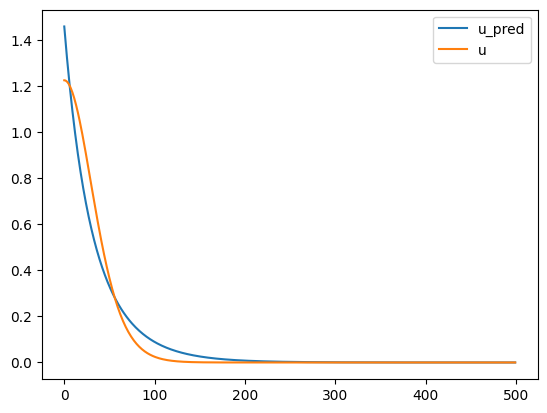

epoch 96 / 500 : loss = 152.25662231445312
epoch 97 / 500 : loss = 152.05758666992188
epoch 98 / 500 : loss = 151.861328125
epoch 99 / 500 : loss = 151.6676483154297


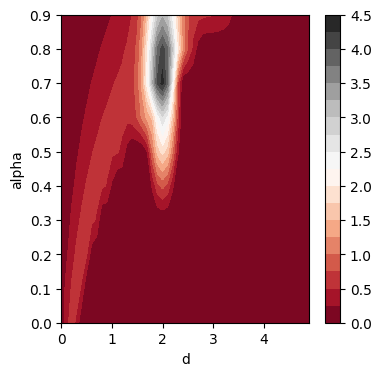

epoch 100 / 500 : loss = 151.4766845703125


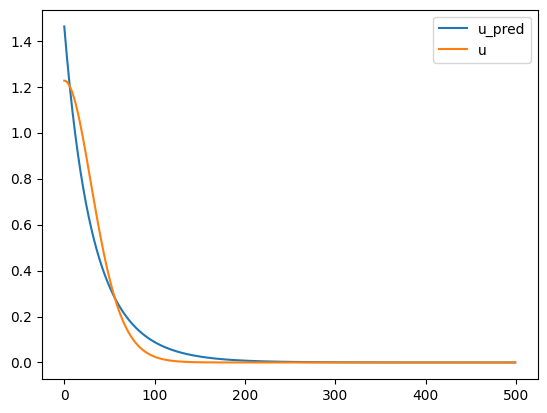

epoch 101 / 500 : loss = 151.28829956054688
epoch 102 / 500 : loss = 151.10324096679688
epoch 103 / 500 : loss = 150.92251586914062
epoch 104 / 500 : loss = 150.74676513671875


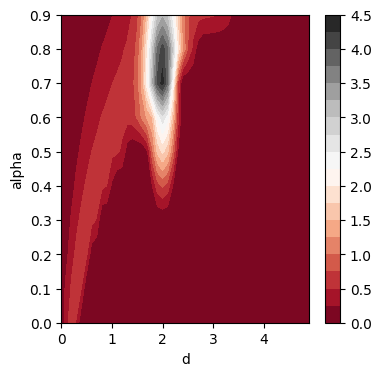

epoch 105 / 500 : loss = 150.57301330566406


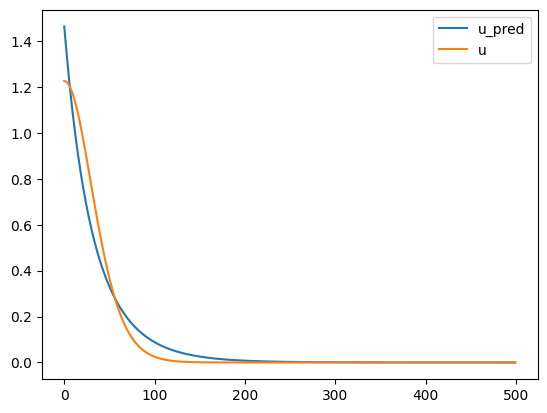

epoch 106 / 500 : loss = 150.40084838867188
epoch 107 / 500 : loss = 150.23098754882812
epoch 108 / 500 : loss = 150.063232421875
epoch 109 / 500 : loss = 149.8976593017578


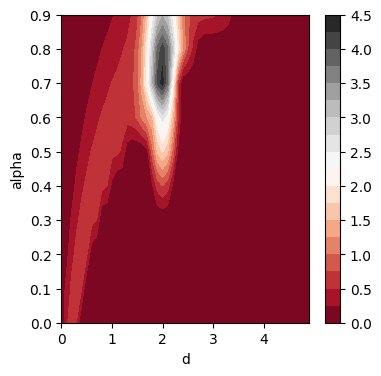

epoch 110 / 500 : loss = 149.73422241210938


epoch 111 / 500 : loss = 149.57237243652344
epoch 112 / 500 : loss = 149.41229248046875
epoch 113 / 500 : loss = 149.25405883789062
epoch 114 / 500 : loss = 149.09774780273438


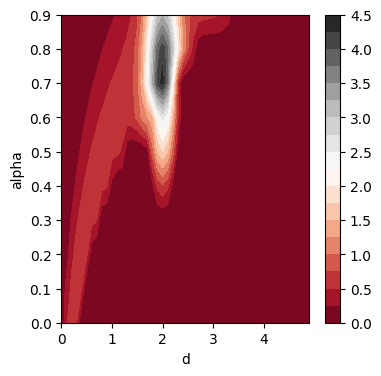

epoch 115 / 500 : loss = 148.9427032470703


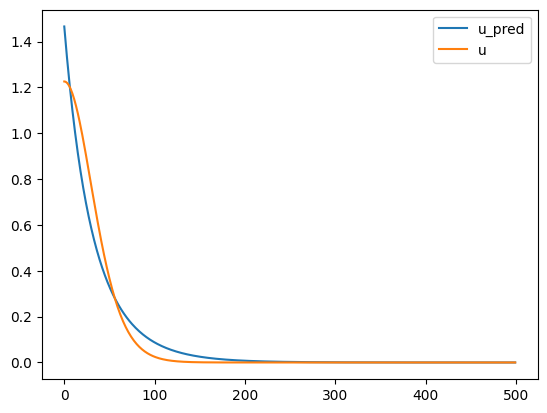

epoch 116 / 500 : loss = 148.78936767578125
epoch 117 / 500 : loss = 148.6374969482422
epoch 118 / 500 : loss = 148.48753356933594
epoch 119 / 500 : loss = 148.33929443359375


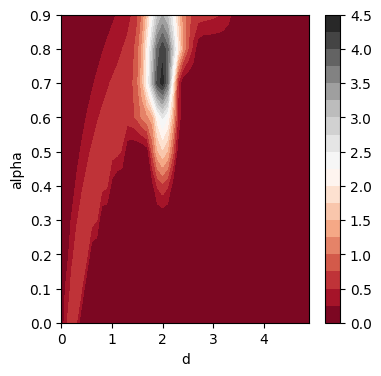

epoch 120 / 500 : loss = 148.19219970703125


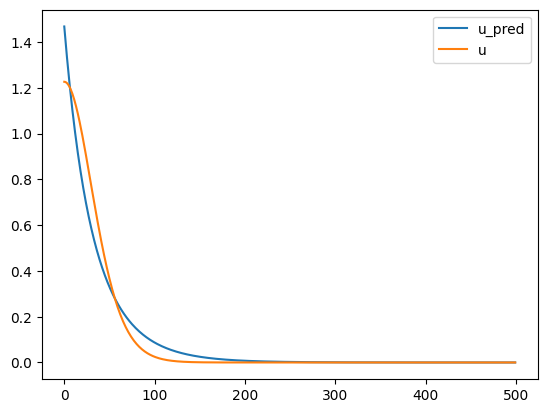

epoch 121 / 500 : loss = 148.04632568359375
epoch 122 / 500 : loss = 147.90185546875
epoch 123 / 500 : loss = 147.759033203125
epoch 124 / 500 : loss = 147.61758422851562


epoch 125 / 500 : loss = 147.47769165039062


epoch 126 / 500 : loss = 147.33877563476562
epoch 127 / 500 : loss = 147.20111083984375
epoch 128 / 500 : loss = 147.06460571289062
epoch 129 / 500 : loss = 146.92929077148438


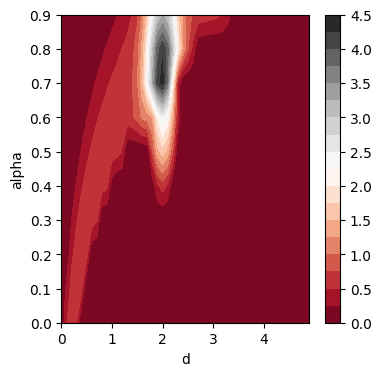

epoch 130 / 500 : loss = 146.7955322265625


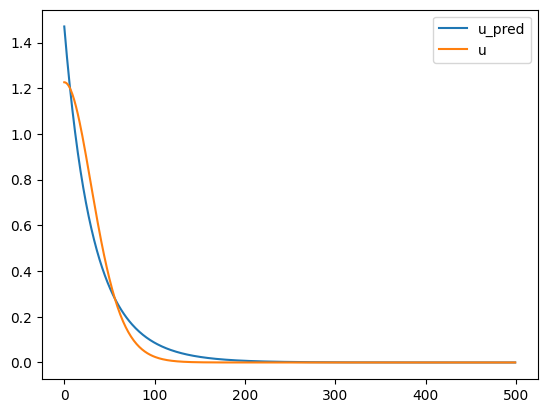

epoch 131 / 500 : loss = 146.6633758544922
epoch 132 / 500 : loss = 146.5321044921875
epoch 133 / 500 : loss = 146.40188598632812
epoch 134 / 500 : loss = 146.27279663085938


epoch 135 / 500 : loss = 146.14488220214844


epoch 136 / 500 : loss = 146.018310546875
epoch 137 / 500 : loss = 145.89334106445312
epoch 138 / 500 : loss = 145.76942443847656
epoch 139 / 500 : loss = 145.64678955078125


epoch 140 / 500 : loss = 145.5254669189453


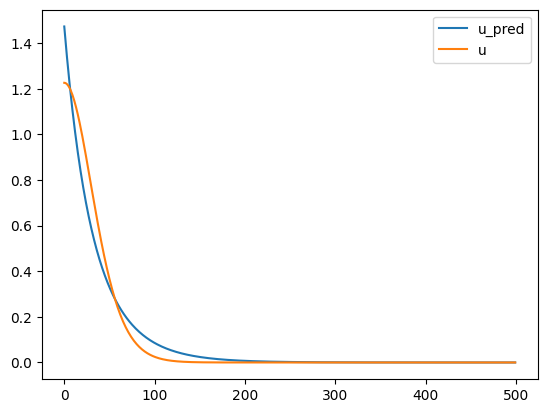

epoch 141 / 500 : loss = 145.40554809570312
epoch 142 / 500 : loss = 145.28713989257812
epoch 143 / 500 : loss = 145.17074584960938
epoch 144 / 500 : loss = 145.05792236328125


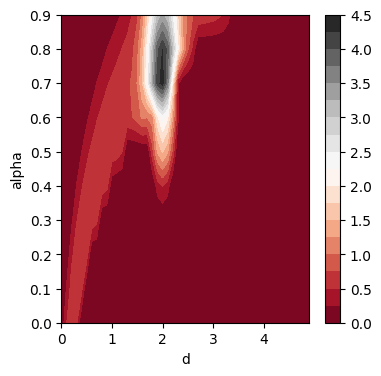

epoch 145 / 500 : loss = 144.94729614257812


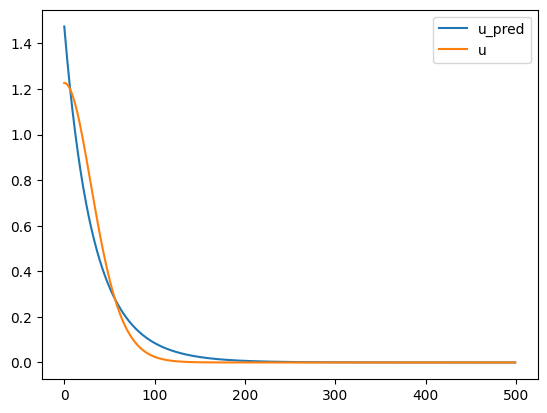

epoch 146 / 500 : loss = 144.8383026123047
epoch 147 / 500 : loss = 144.73040771484375
epoch 148 / 500 : loss = 144.62371826171875
epoch 149 / 500 : loss = 144.51815795898438


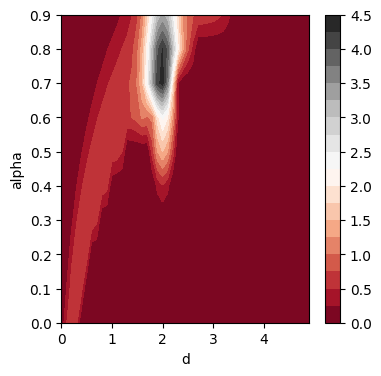

epoch 150 / 500 : loss = 144.41357421875


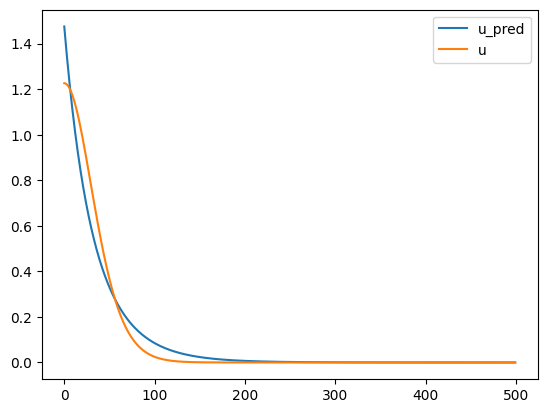

epoch 151 / 500 : loss = 144.30975341796875
epoch 152 / 500 : loss = 144.20657348632812
epoch 153 / 500 : loss = 144.10433959960938
epoch 154 / 500 : loss = 144.00277709960938


epoch 155 / 500 : loss = 143.90164184570312


epoch 156 / 500 : loss = 143.8011016845703
epoch 157 / 500 : loss = 143.70135498046875
epoch 158 / 500 : loss = 143.60244750976562
epoch 159 / 500 : loss = 143.50416564941406


epoch 160 / 500 : loss = 143.40646362304688


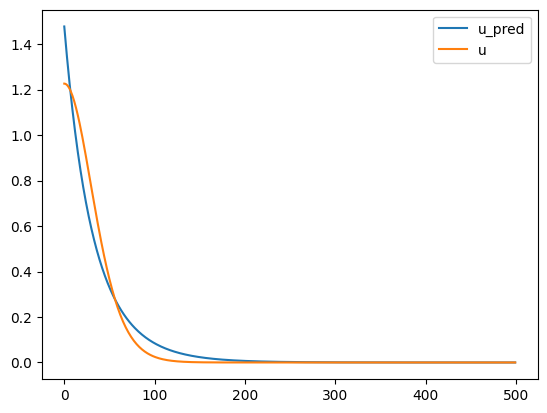

epoch 161 / 500 : loss = 143.30926513671875
epoch 162 / 500 : loss = 143.212890625
epoch 163 / 500 : loss = 143.11700439453125
epoch 164 / 500 : loss = 143.02154541015625


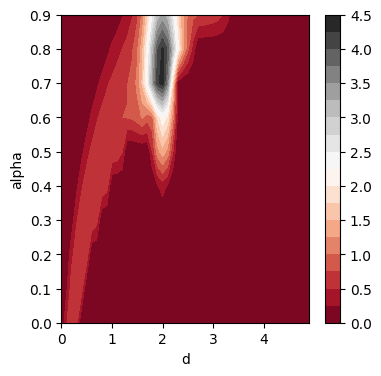

epoch 165 / 500 : loss = 142.92660522460938


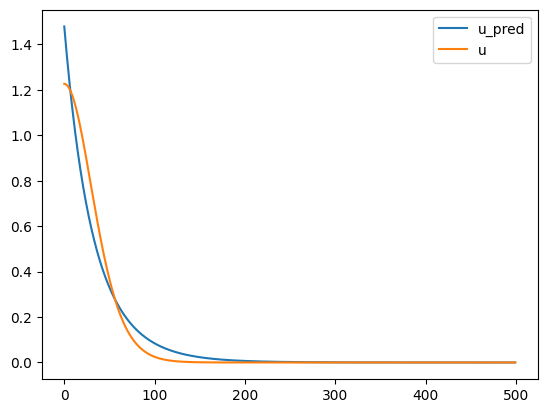

epoch 166 / 500 : loss = 142.83251953125
epoch 167 / 500 : loss = 142.739013671875
epoch 168 / 500 : loss = 142.64596557617188
epoch 169 / 500 : loss = 142.55337524414062


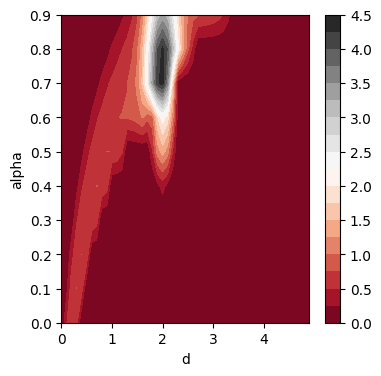

epoch 170 / 500 : loss = 142.46109008789062


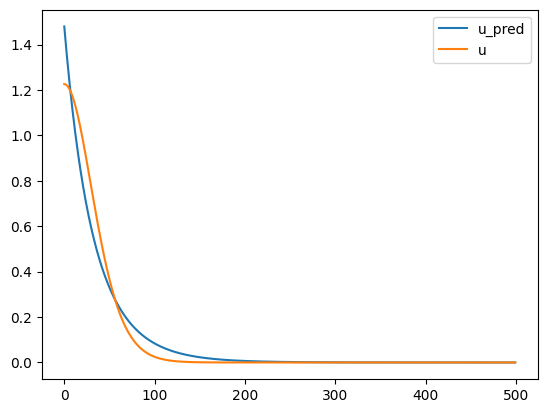

epoch 171 / 500 : loss = 142.36947631835938
epoch 172 / 500 : loss = 142.27859497070312
epoch 173 / 500 : loss = 142.18838500976562
epoch 174 / 500 : loss = 142.09886169433594


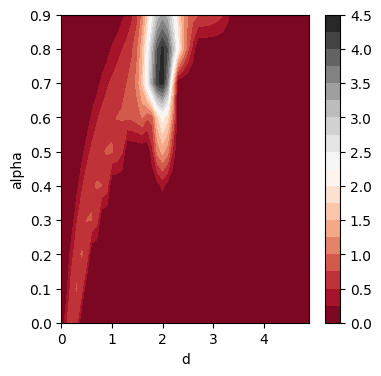

epoch 175 / 500 : loss = 142.00967407226562


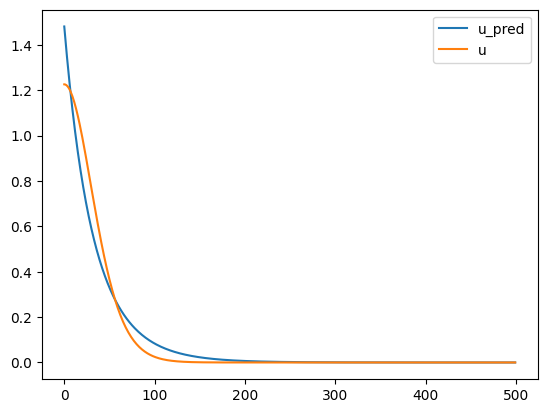

epoch 176 / 500 : loss = 141.92092895507812
epoch 177 / 500 : loss = 141.8325653076172
epoch 178 / 500 : loss = 141.74456787109375
epoch 179 / 500 : loss = 141.65692138671875


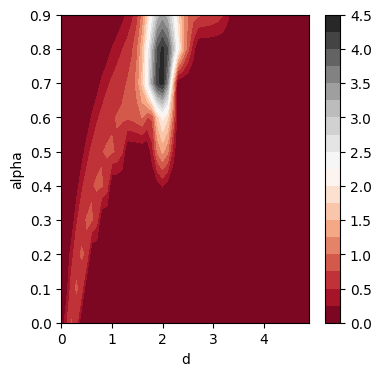

epoch 180 / 500 : loss = 141.5699920654297


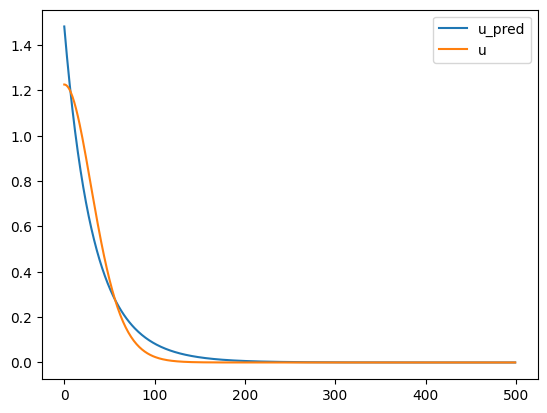

epoch 181 / 500 : loss = 141.4838104248047
epoch 182 / 500 : loss = 141.39842224121094
epoch 183 / 500 : loss = 141.31350708007812
epoch 184 / 500 : loss = 141.22921752929688


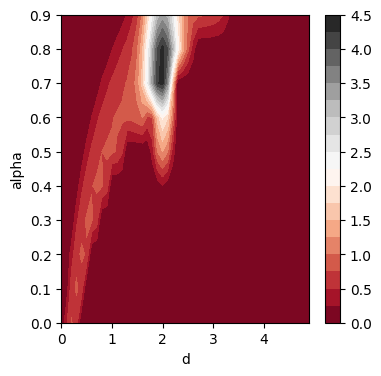

epoch 185 / 500 : loss = 141.14523315429688


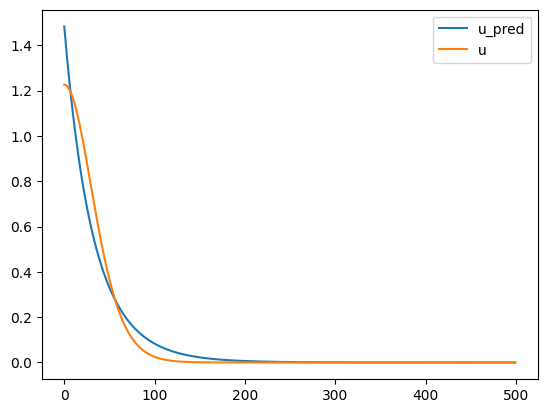

epoch 186 / 500 : loss = 141.0617218017578
epoch 187 / 500 : loss = 140.97891235351562
epoch 188 / 500 : loss = 140.89688110351562
epoch 189 / 500 : loss = 140.81568908691406


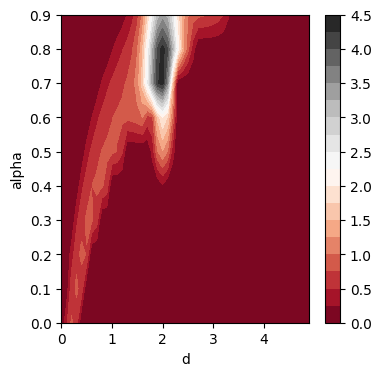

epoch 190 / 500 : loss = 140.73529052734375


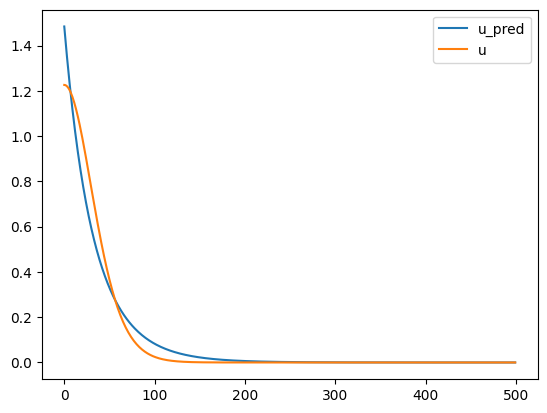

epoch 191 / 500 : loss = 140.6557159423828
epoch 192 / 500 : loss = 140.57684326171875
epoch 193 / 500 : loss = 140.49856567382812
epoch 194 / 500 : loss = 140.4208984375


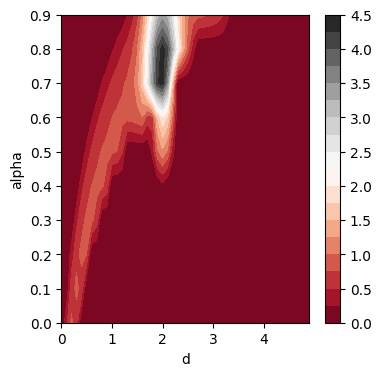

epoch 195 / 500 : loss = 140.34371948242188


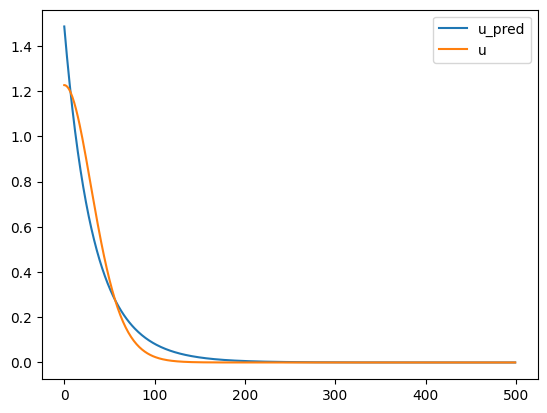

epoch 196 / 500 : loss = 140.26730346679688
epoch 197 / 500 : loss = 140.19203186035156
epoch 198 / 500 : loss = 140.11892700195312
epoch 199 / 500 : loss = 140.04800415039062


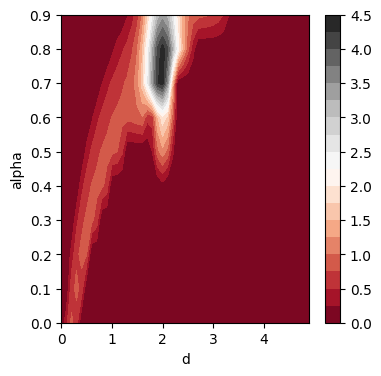

epoch 200 / 500 : loss = 139.97866821289062


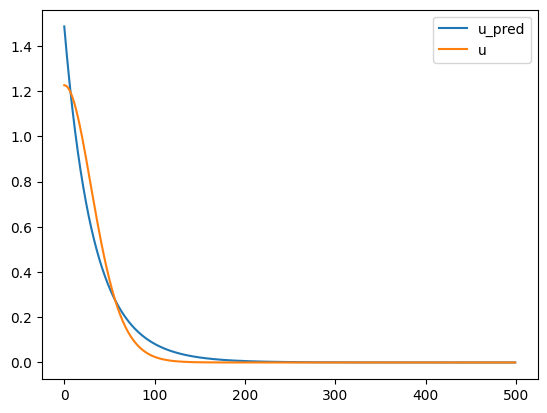

epoch 201 / 500 : loss = 139.90997314453125
epoch 202 / 500 : loss = 139.84202575683594
epoch 203 / 500 : loss = 139.77467346191406
epoch 204 / 500 : loss = 139.7076416015625


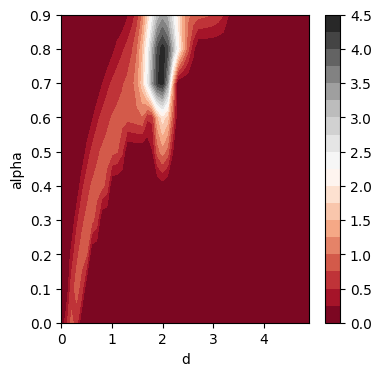

epoch 205 / 500 : loss = 139.6409149169922


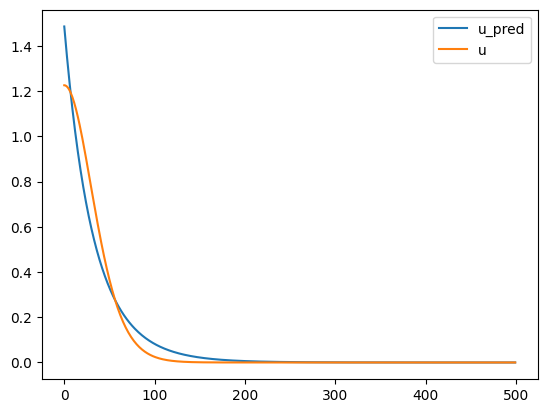

epoch 206 / 500 : loss = 139.57469177246094
epoch 207 / 500 : loss = 139.5089111328125
epoch 208 / 500 : loss = 139.44354248046875
epoch 209 / 500 : loss = 139.37857055664062


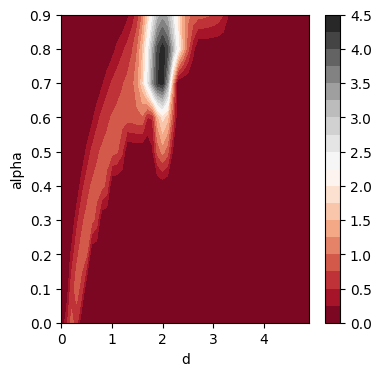

epoch 210 / 500 : loss = 139.31394958496094


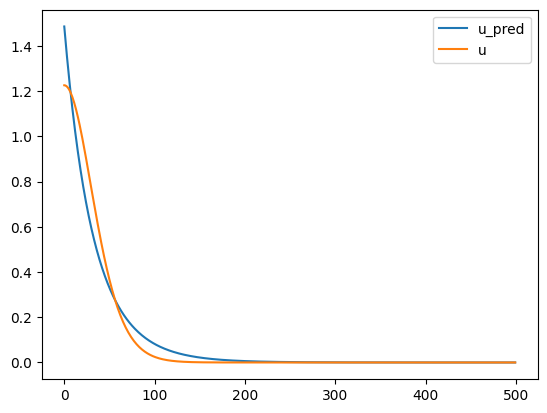

epoch 211 / 500 : loss = 139.24954223632812
epoch 212 / 500 : loss = 139.18560791015625
epoch 213 / 500 : loss = 139.12277221679688
epoch 214 / 500 : loss = 139.0604248046875


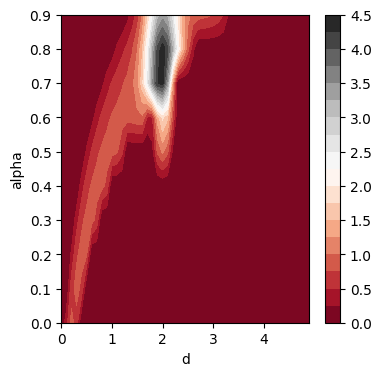

epoch 215 / 500 : loss = 138.99859619140625


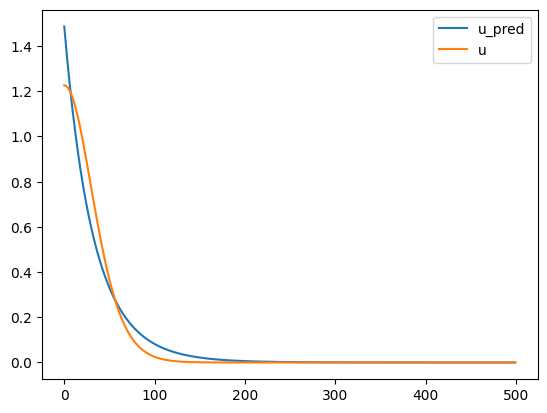

epoch 216 / 500 : loss = 138.93710327148438
epoch 217 / 500 : loss = 138.8760986328125
epoch 218 / 500 : loss = 138.8155059814453
epoch 219 / 500 : loss = 138.75531005859375


epoch 220 / 500 : loss = 138.69613647460938


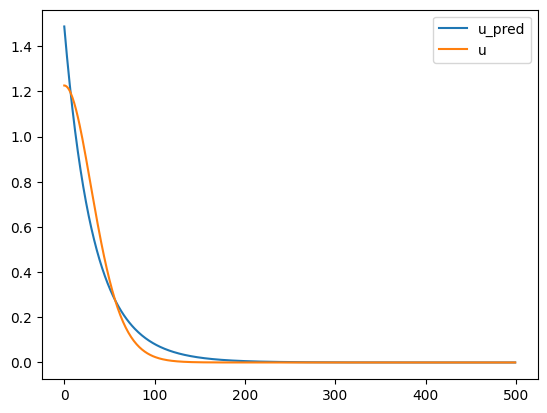

epoch 221 / 500 : loss = 138.63818359375
epoch 222 / 500 : loss = 138.58082580566406
epoch 223 / 500 : loss = 138.52423095703125
epoch 224 / 500 : loss = 138.4677734375


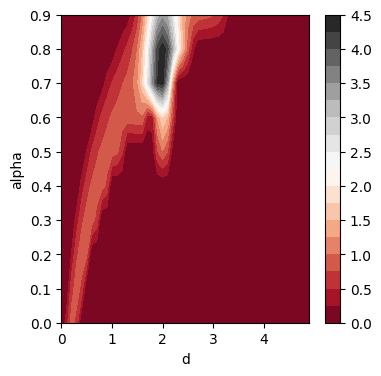

epoch 225 / 500 : loss = 138.41156005859375


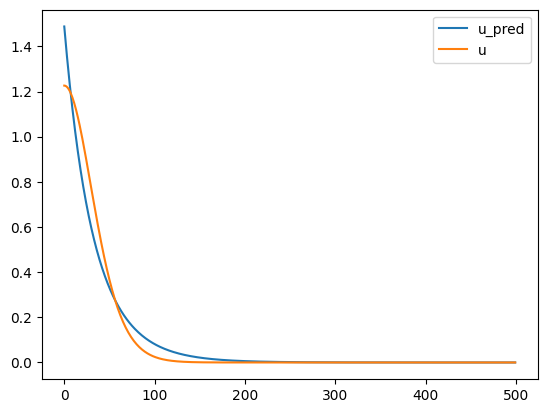

epoch 226 / 500 : loss = 138.35586547851562
epoch 227 / 500 : loss = 138.3003387451172
epoch 228 / 500 : loss = 138.24508666992188
epoch 229 / 500 : loss = 138.1903839111328


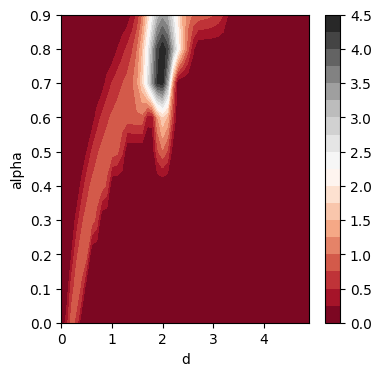

epoch 230 / 500 : loss = 138.13577270507812


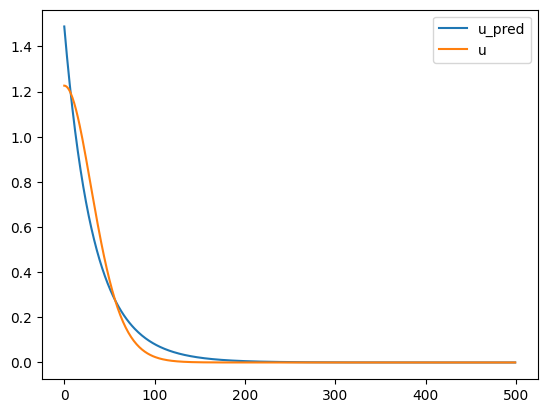

epoch 231 / 500 : loss = 138.08139038085938
epoch 232 / 500 : loss = 138.02743530273438
epoch 233 / 500 : loss = 137.97364807128906
epoch 234 / 500 : loss = 137.92007446289062


epoch 235 / 500 : loss = 137.8668212890625


epoch 236 / 500 : loss = 137.81378173828125
epoch 237 / 500 : loss = 137.76089477539062
epoch 238 / 500 : loss = 137.708251953125
epoch 239 / 500 : loss = 137.6558837890625


epoch 240 / 500 : loss = 137.6039276123047


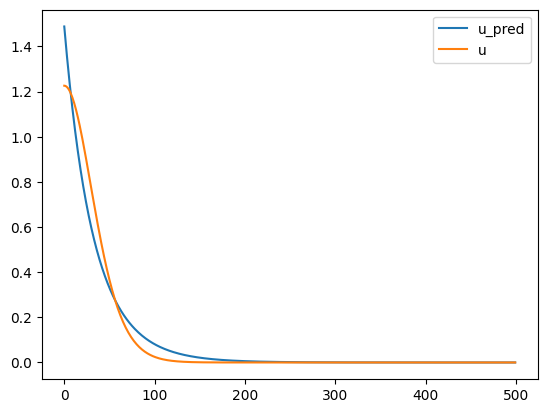

epoch 241 / 500 : loss = 137.55233764648438
epoch 242 / 500 : loss = 137.5010528564453
epoch 243 / 500 : loss = 137.4507598876953
epoch 244 / 500 : loss = 137.4010009765625


epoch 245 / 500 : loss = 137.3513946533203


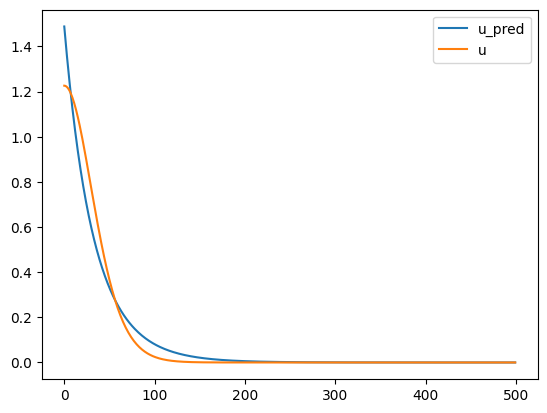

epoch 246 / 500 : loss = 137.3021697998047
epoch 247 / 500 : loss = 137.2532958984375
epoch 248 / 500 : loss = 137.20468139648438
epoch 249 / 500 : loss = 137.15618896484375


epoch 250 / 500 : loss = 137.10791015625


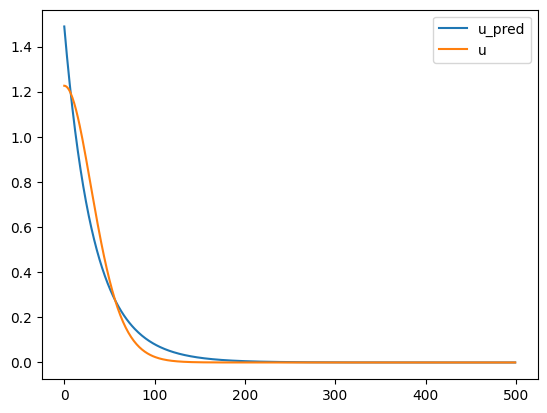

epoch 251 / 500 : loss = 137.05975341796875
epoch 252 / 500 : loss = 137.011962890625
epoch 253 / 500 : loss = 136.96453857421875
epoch 254 / 500 : loss = 136.9173583984375


epoch 255 / 500 : loss = 136.87026977539062


epoch 256 / 500 : loss = 136.8235321044922
epoch 257 / 500 : loss = 136.7769012451172
epoch 258 / 500 : loss = 136.73040771484375
epoch 259 / 500 : loss = 136.68399047851562


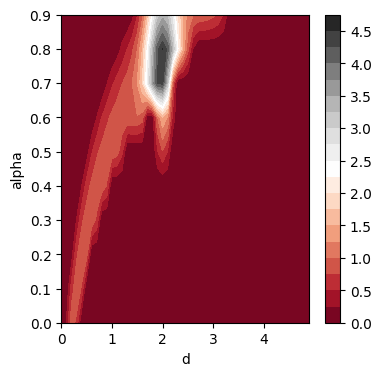

epoch 260 / 500 : loss = 136.63778686523438


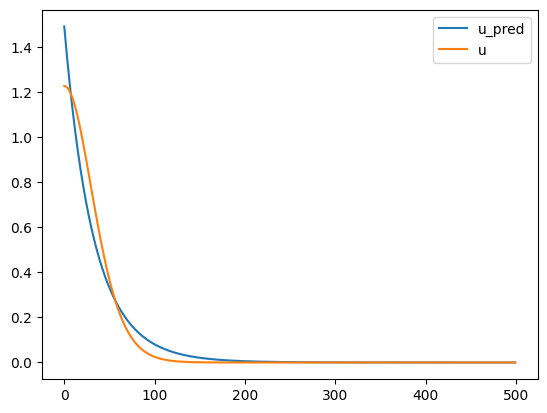

epoch 261 / 500 : loss = 136.5916748046875
epoch 262 / 500 : loss = 136.5457000732422
epoch 263 / 500 : loss = 136.49984741210938
epoch 264 / 500 : loss = 136.45413208007812


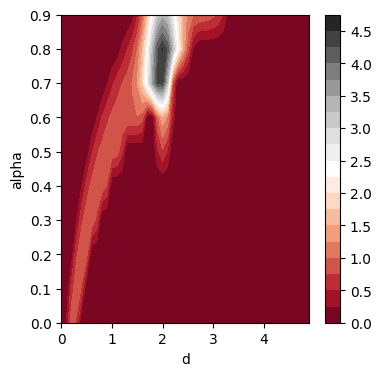

epoch 265 / 500 : loss = 136.40859985351562


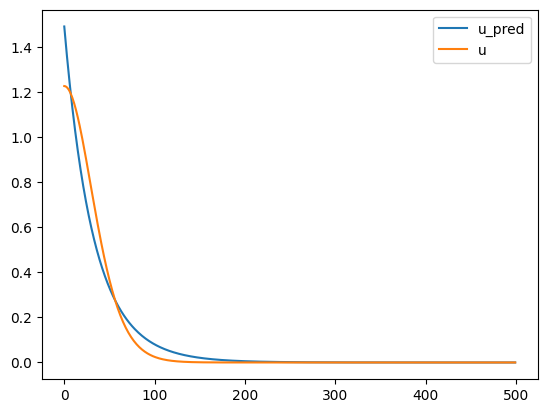

epoch 266 / 500 : loss = 136.36312866210938
epoch 267 / 500 : loss = 136.31781005859375
epoch 268 / 500 : loss = 136.2725830078125
epoch 269 / 500 : loss = 136.22744750976562


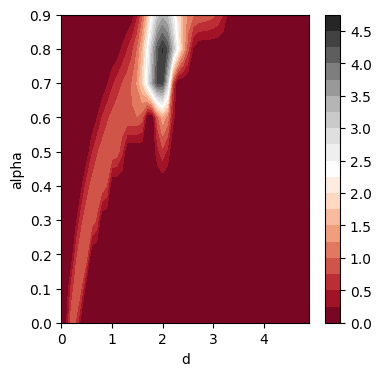

epoch 270 / 500 : loss = 136.18252563476562


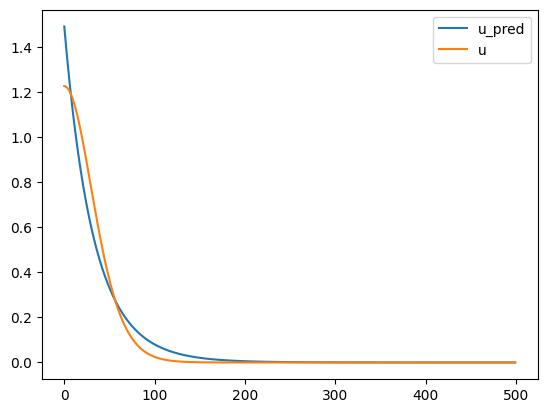

epoch 271 / 500 : loss = 136.1378631591797
epoch 272 / 500 : loss = 136.09341430664062
epoch 273 / 500 : loss = 136.0489501953125
epoch 274 / 500 : loss = 136.0046844482422


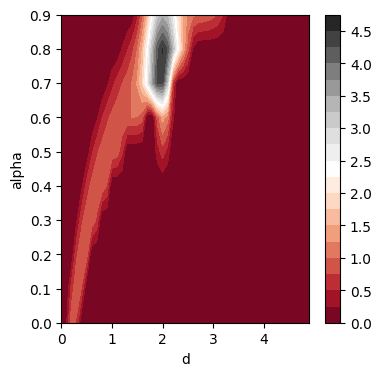

epoch 275 / 500 : loss = 135.96055603027344


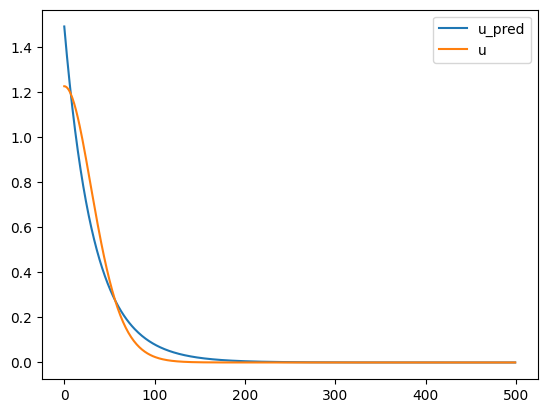

epoch 276 / 500 : loss = 135.91650390625
epoch 277 / 500 : loss = 135.87252807617188
epoch 278 / 500 : loss = 135.82858276367188
epoch 279 / 500 : loss = 135.7848358154297


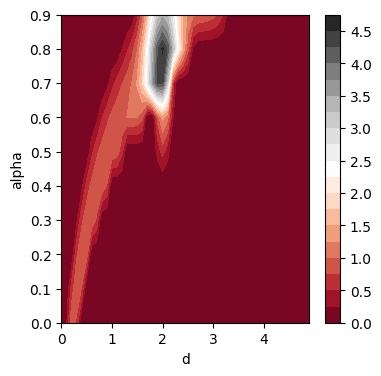

epoch 280 / 500 : loss = 135.7412109375


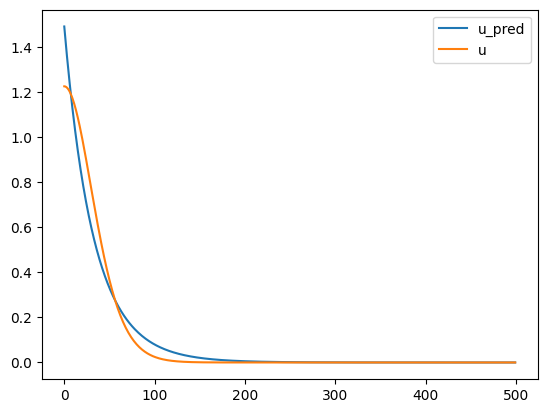

epoch 281 / 500 : loss = 135.69789123535156
epoch 282 / 500 : loss = 135.65469360351562
epoch 283 / 500 : loss = 135.6115264892578
epoch 284 / 500 : loss = 135.5684814453125


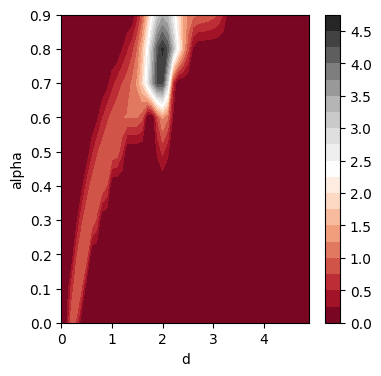

epoch 285 / 500 : loss = 135.525634765625


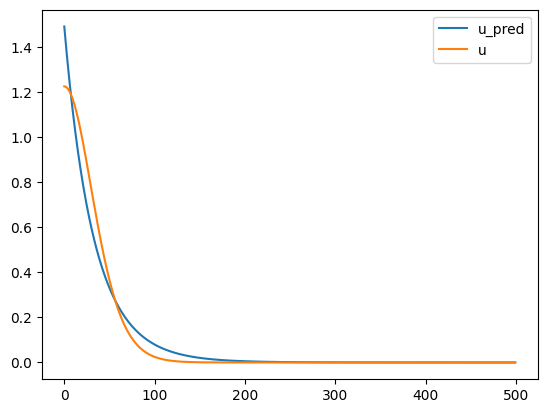

epoch 286 / 500 : loss = 135.4827880859375
epoch 287 / 500 : loss = 135.44012451171875
epoch 288 / 500 : loss = 135.39773559570312
epoch 289 / 500 : loss = 135.35540771484375


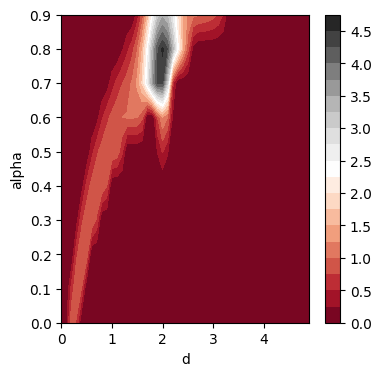

epoch 290 / 500 : loss = 135.3131103515625


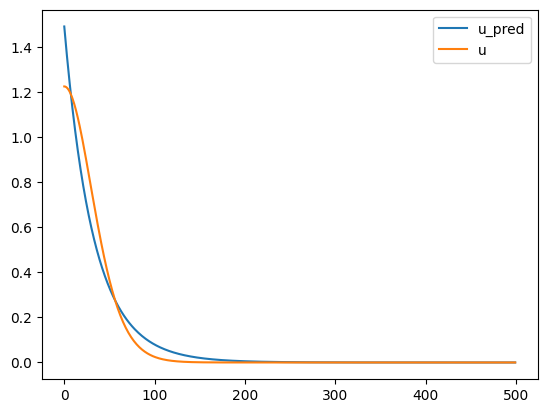

epoch 291 / 500 : loss = 135.27110290527344
epoch 292 / 500 : loss = 135.22921752929688
epoch 293 / 500 : loss = 135.18751525878906
epoch 294 / 500 : loss = 135.14608764648438


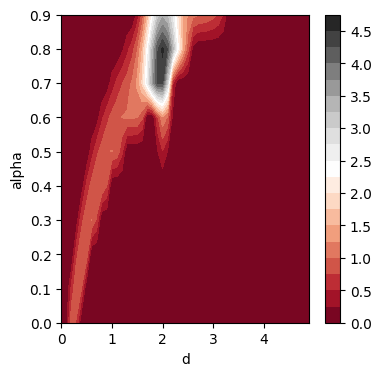

epoch 295 / 500 : loss = 135.10464477539062


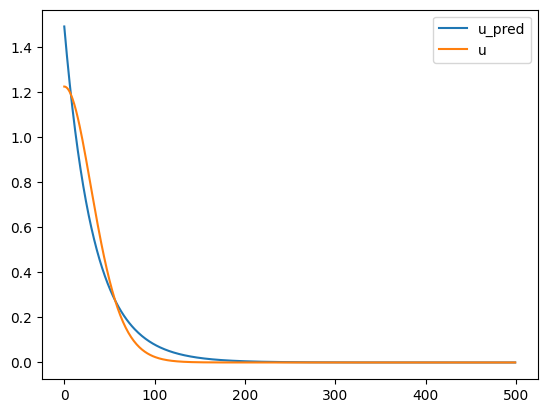

epoch 296 / 500 : loss = 135.06329345703125
epoch 297 / 500 : loss = 135.0220489501953
epoch 298 / 500 : loss = 134.9808807373047
epoch 299 / 500 : loss = 134.93984985351562


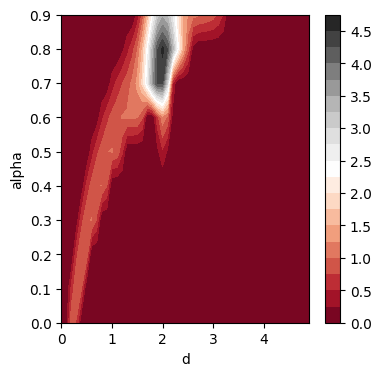

epoch 300 / 500 : loss = 134.89895629882812


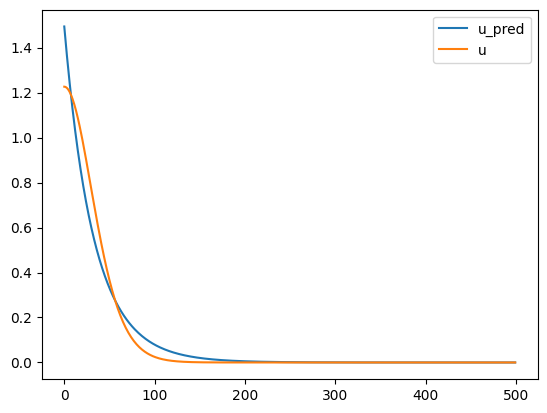

epoch 301 / 500 : loss = 134.85818481445312
epoch 302 / 500 : loss = 134.8175811767578
epoch 303 / 500 : loss = 134.7771453857422
epoch 304 / 500 : loss = 134.73678588867188


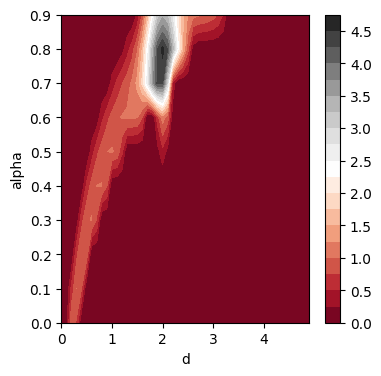

epoch 305 / 500 : loss = 134.69659423828125


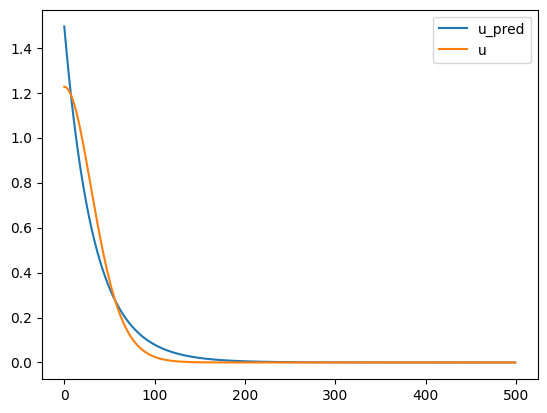

epoch 306 / 500 : loss = 134.6566619873047
epoch 307 / 500 : loss = 134.61685180664062
epoch 308 / 500 : loss = 134.57728576660156
epoch 309 / 500 : loss = 134.5377655029297


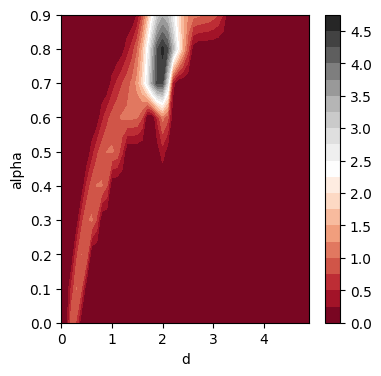

epoch 310 / 500 : loss = 134.4984130859375


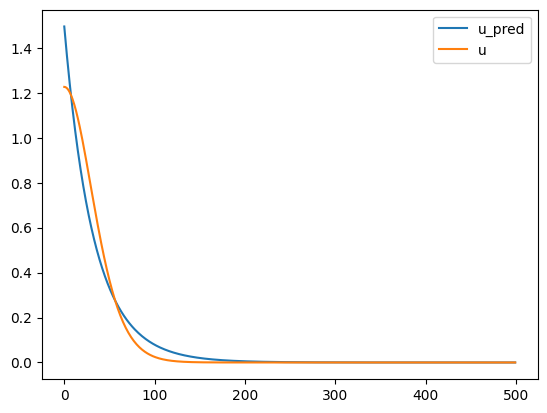

epoch 311 / 500 : loss = 134.4591827392578
epoch 312 / 500 : loss = 134.4200897216797
epoch 313 / 500 : loss = 134.3812255859375
epoch 314 / 500 : loss = 134.34263610839844


epoch 315 / 500 : loss = 134.30438232421875


epoch 316 / 500 : loss = 134.26651000976562
epoch 317 / 500 : loss = 134.22882080078125
epoch 318 / 500 : loss = 134.19125366210938
epoch 319 / 500 : loss = 134.1538543701172


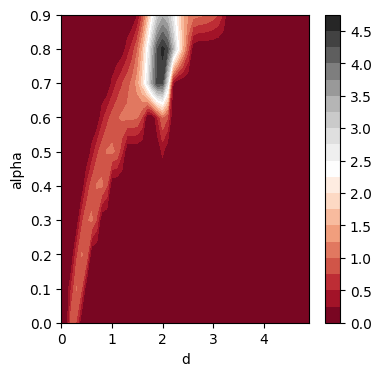

epoch 320 / 500 : loss = 134.1168212890625


epoch 321 / 500 : loss = 134.08067321777344
epoch 322 / 500 : loss = 134.04513549804688
epoch 323 / 500 : loss = 134.00985717773438
epoch 324 / 500 : loss = 133.9748077392578


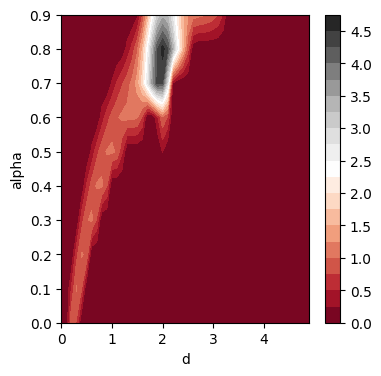

epoch 325 / 500 : loss = 133.93997192382812


epoch 326 / 500 : loss = 133.90542602539062
epoch 327 / 500 : loss = 133.8715057373047
epoch 328 / 500 : loss = 133.8380126953125
epoch 329 / 500 : loss = 133.80503845214844


epoch 330 / 500 : loss = 133.77243041992188


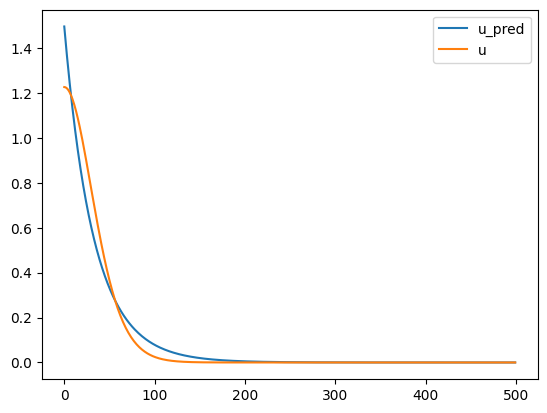

epoch 331 / 500 : loss = 133.74021911621094
epoch 332 / 500 : loss = 133.7083740234375
epoch 333 / 500 : loss = 133.67677307128906
epoch 334 / 500 : loss = 133.64553833007812


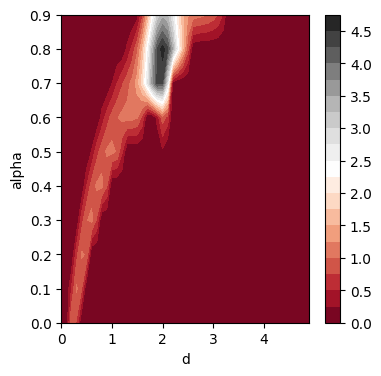

epoch 335 / 500 : loss = 133.61459350585938


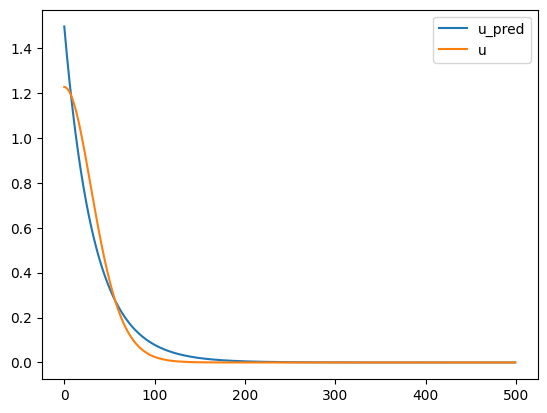

epoch 336 / 500 : loss = 133.5840606689453
epoch 337 / 500 : loss = 133.55377197265625
epoch 338 / 500 : loss = 133.5238037109375
epoch 339 / 500 : loss = 133.49420166015625


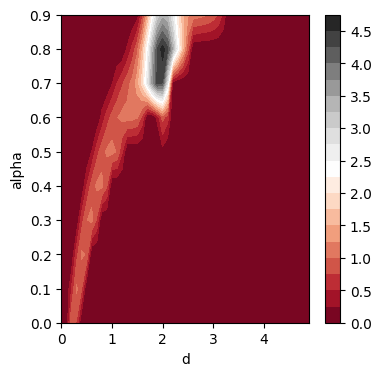

epoch 340 / 500 : loss = 133.46490478515625


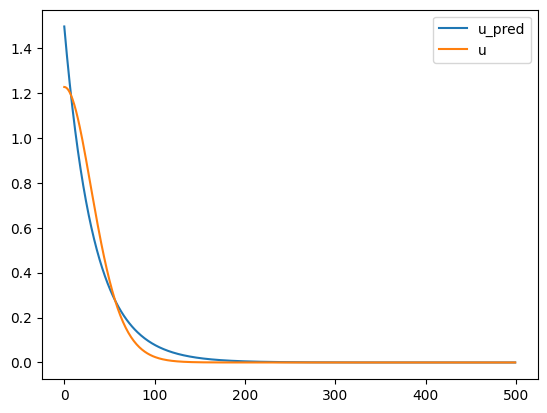

epoch 341 / 500 : loss = 133.43603515625
epoch 342 / 500 : loss = 133.40731811523438
epoch 343 / 500 : loss = 133.37884521484375
epoch 344 / 500 : loss = 133.35072326660156


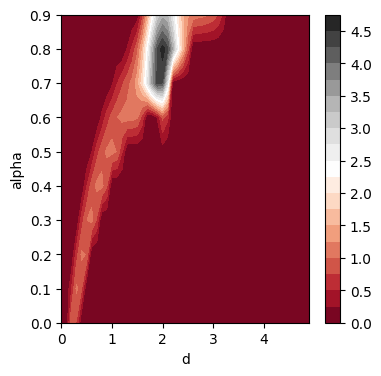

epoch 345 / 500 : loss = 133.3229217529297


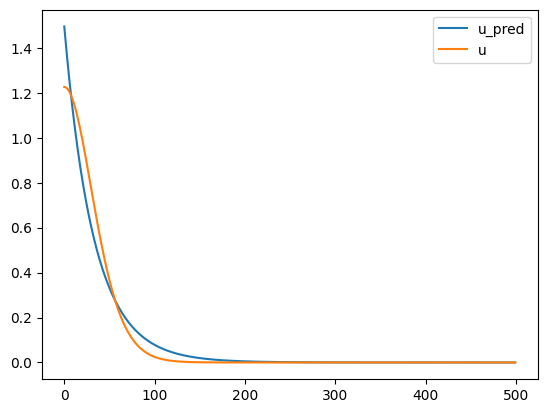

epoch 346 / 500 : loss = 133.29530334472656
epoch 347 / 500 : loss = 133.267822265625
epoch 348 / 500 : loss = 133.2404022216797
epoch 349 / 500 : loss = 133.21310424804688


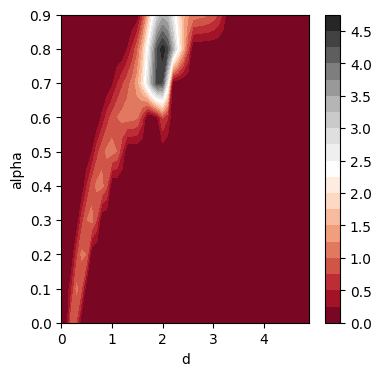

epoch 350 / 500 : loss = 133.18600463867188


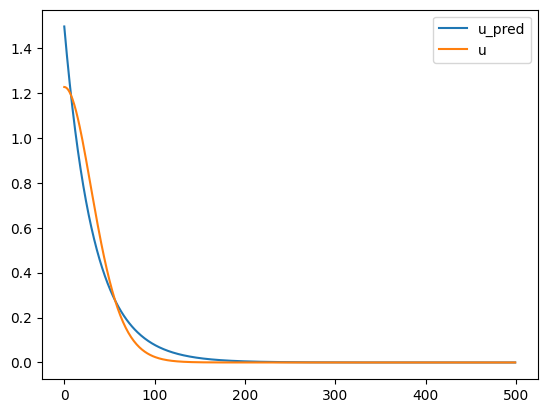

epoch 351 / 500 : loss = 133.15896606445312
epoch 352 / 500 : loss = 133.13204956054688
epoch 353 / 500 : loss = 133.10519409179688
epoch 354 / 500 : loss = 133.07843017578125


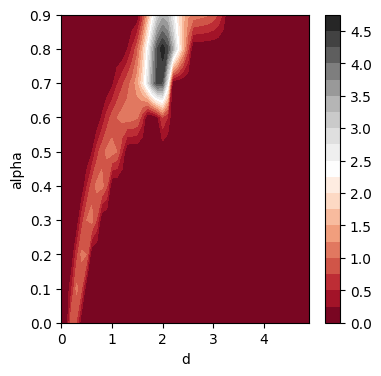

epoch 355 / 500 : loss = 133.0517120361328


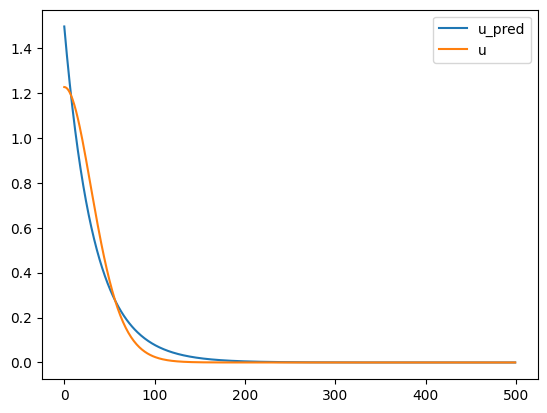

epoch 356 / 500 : loss = 133.0251007080078
epoch 357 / 500 : loss = 132.99874877929688
epoch 358 / 500 : loss = 132.97286987304688
epoch 359 / 500 : loss = 132.94728088378906


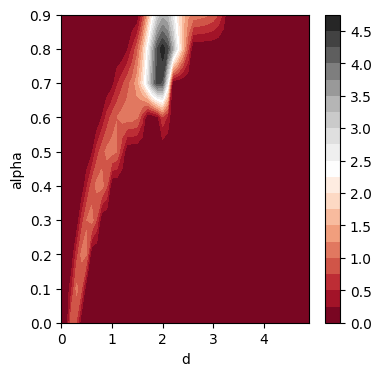

epoch 360 / 500 : loss = 132.92193603515625


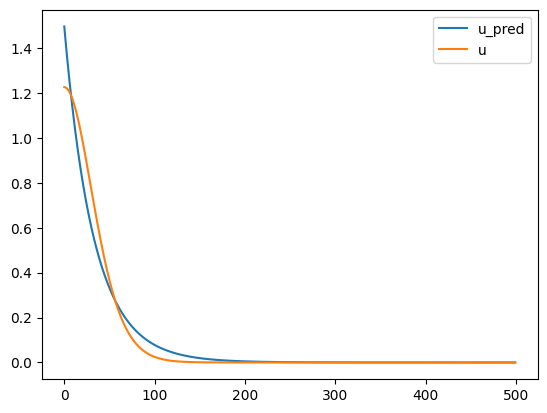

epoch 361 / 500 : loss = 132.8967742919922
epoch 362 / 500 : loss = 132.87184143066406
epoch 363 / 500 : loss = 132.84725952148438
epoch 364 / 500 : loss = 132.82284545898438


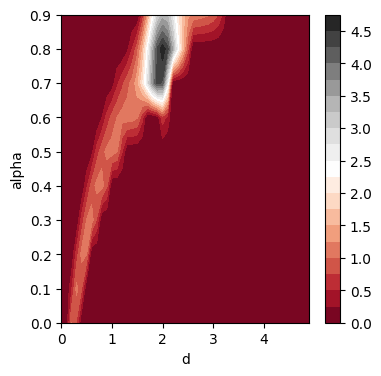

epoch 365 / 500 : loss = 132.798583984375


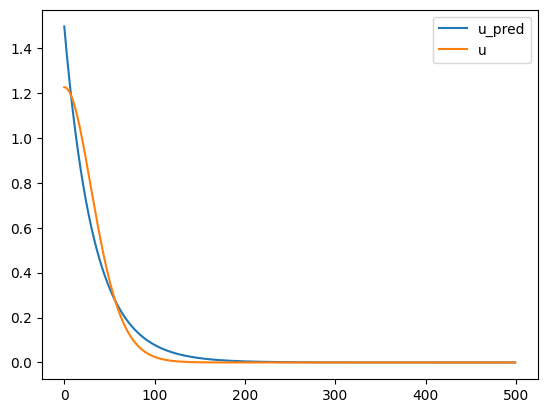

epoch 366 / 500 : loss = 132.7745361328125
epoch 367 / 500 : loss = 132.75067138671875
epoch 368 / 500 : loss = 132.72703552246094
epoch 369 / 500 : loss = 132.70370483398438


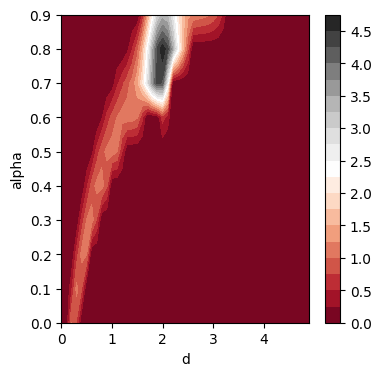

epoch 370 / 500 : loss = 132.68072509765625


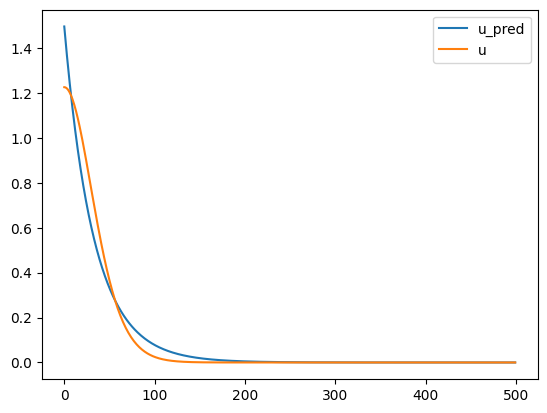

epoch 371 / 500 : loss = 132.65786743164062
epoch 372 / 500 : loss = 132.63511657714844
epoch 373 / 500 : loss = 132.61253356933594
epoch 374 / 500 : loss = 132.59022521972656


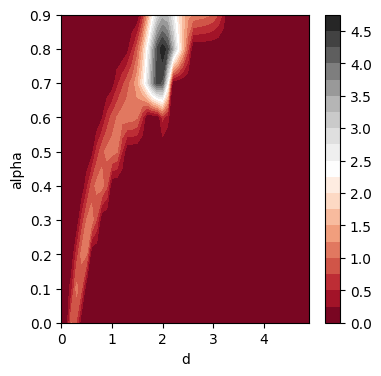

epoch 375 / 500 : loss = 132.568115234375


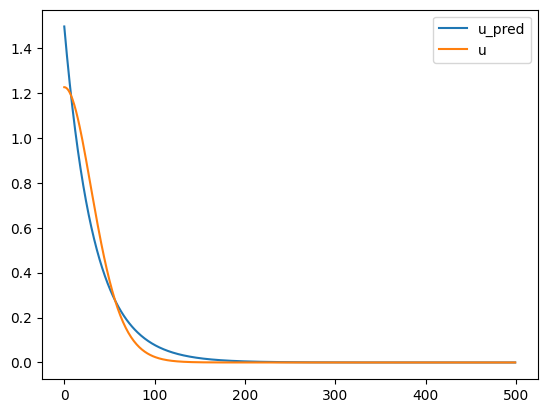

epoch 376 / 500 : loss = 132.54611206054688
epoch 377 / 500 : loss = 132.5242919921875
epoch 378 / 500 : loss = 132.50259399414062
epoch 379 / 500 : loss = 132.48097229003906


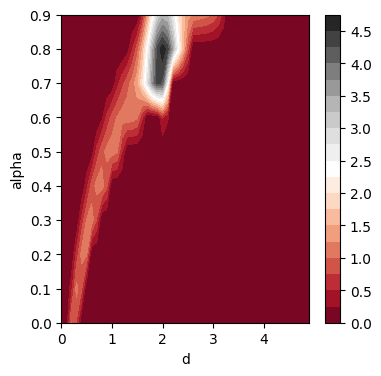

epoch 380 / 500 : loss = 132.45953369140625


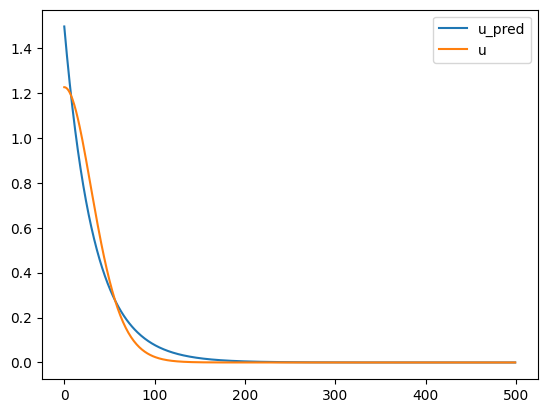

epoch 381 / 500 : loss = 132.43814086914062
epoch 382 / 500 : loss = 132.4168243408203
epoch 383 / 500 : loss = 132.39556884765625
epoch 384 / 500 : loss = 132.37435913085938


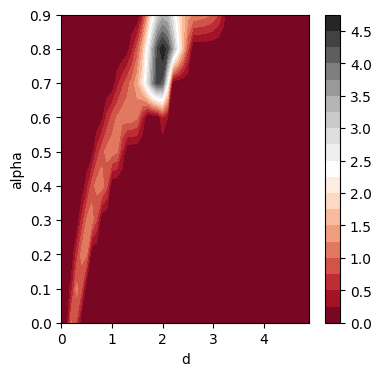

epoch 385 / 500 : loss = 132.3531951904297


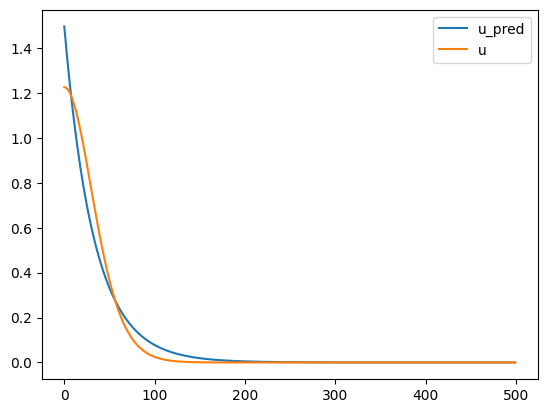

epoch 386 / 500 : loss = 132.33212280273438
epoch 387 / 500 : loss = 132.31124877929688
epoch 388 / 500 : loss = 132.29042053222656
epoch 389 / 500 : loss = 132.2696990966797


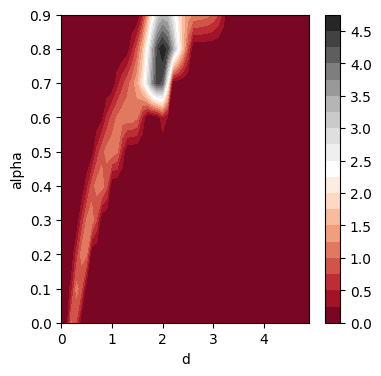

epoch 390 / 500 : loss = 132.2490692138672


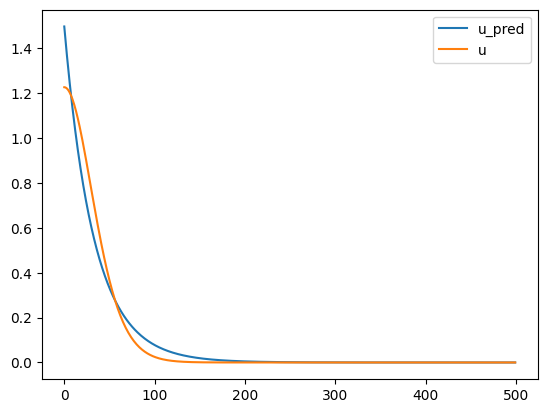

epoch 391 / 500 : loss = 132.2284393310547
epoch 392 / 500 : loss = 132.20785522460938
epoch 393 / 500 : loss = 132.18740844726562
epoch 394 / 500 : loss = 132.1669921875


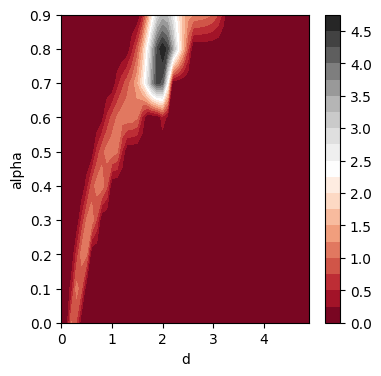

epoch 395 / 500 : loss = 132.14659118652344


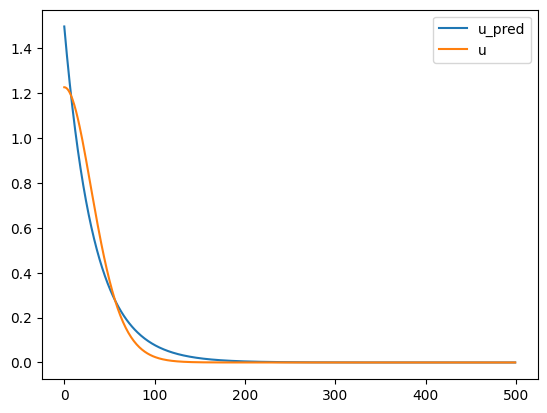

epoch 396 / 500 : loss = 132.12628173828125
epoch 397 / 500 : loss = 132.10604858398438
epoch 398 / 500 : loss = 132.0858612060547
epoch 399 / 500 : loss = 132.06576538085938


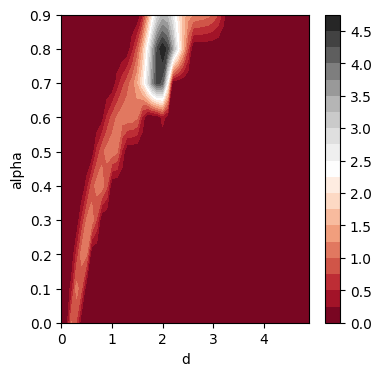

epoch 400 / 500 : loss = 132.04571533203125


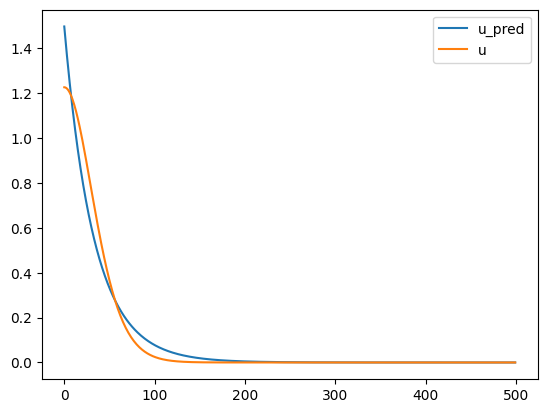

epoch 401 / 500 : loss = 132.02577209472656
epoch 402 / 500 : loss = 132.0059356689453
epoch 403 / 500 : loss = 131.98614501953125
epoch 404 / 500 : loss = 131.9664306640625


epoch 405 / 500 : loss = 131.94680786132812


epoch 406 / 500 : loss = 131.92718505859375
epoch 407 / 500 : loss = 131.90760803222656
epoch 408 / 500 : loss = 131.8882598876953
epoch 409 / 500 : loss = 131.8690185546875


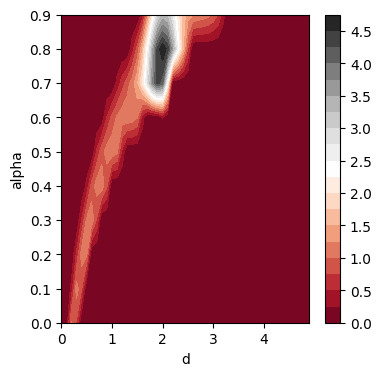

epoch 410 / 500 : loss = 131.84991455078125


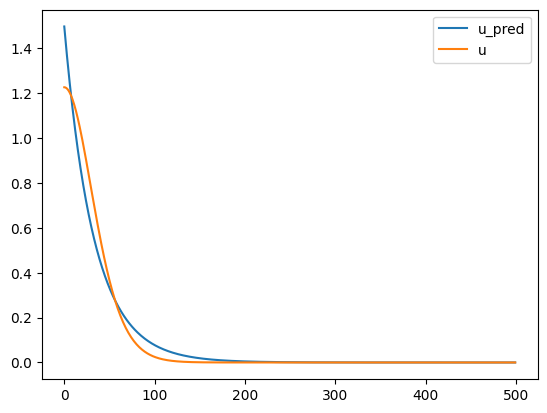

epoch 411 / 500 : loss = 131.8309326171875
epoch 412 / 500 : loss = 131.81207275390625
epoch 413 / 500 : loss = 131.79330444335938
epoch 414 / 500 : loss = 131.77467346191406


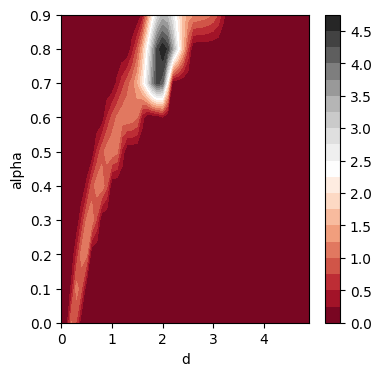

epoch 415 / 500 : loss = 131.7562255859375


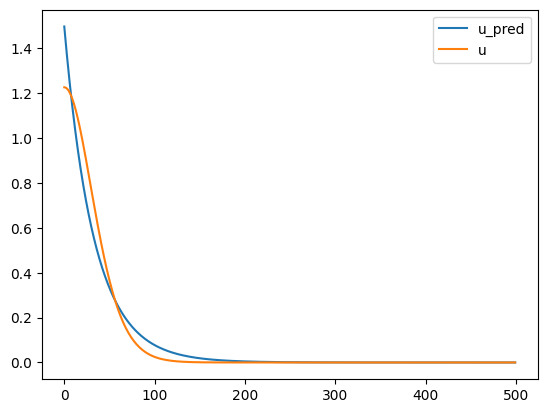

epoch 416 / 500 : loss = 131.73782348632812
epoch 417 / 500 : loss = 131.71949768066406
epoch 418 / 500 : loss = 131.70123291015625
epoch 419 / 500 : loss = 131.68304443359375


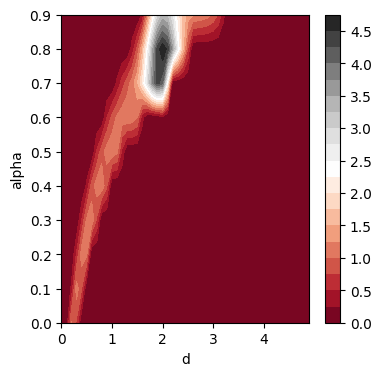

epoch 420 / 500 : loss = 131.6650390625


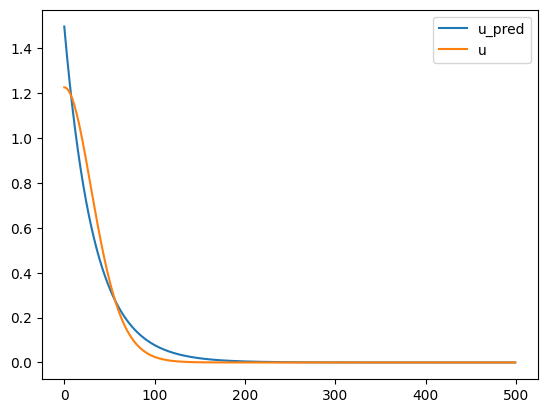

epoch 421 / 500 : loss = 131.6470947265625
epoch 422 / 500 : loss = 131.62925720214844
epoch 423 / 500 : loss = 131.6114959716797
epoch 424 / 500 : loss = 131.59384155273438


epoch 425 / 500 : loss = 131.57632446289062


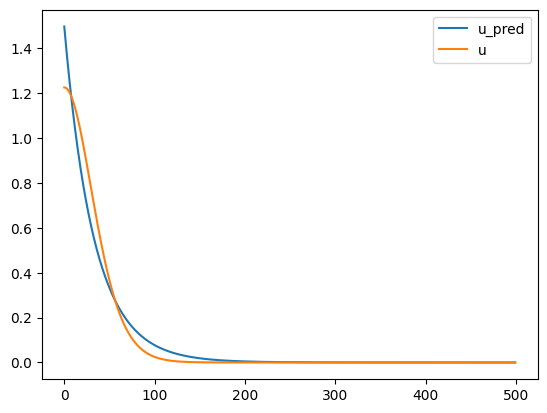

epoch 426 / 500 : loss = 131.55886840820312
epoch 427 / 500 : loss = 131.54150390625
epoch 428 / 500 : loss = 131.5242156982422
epoch 429 / 500 : loss = 131.50701904296875


epoch 430 / 500 : loss = 131.48992919921875


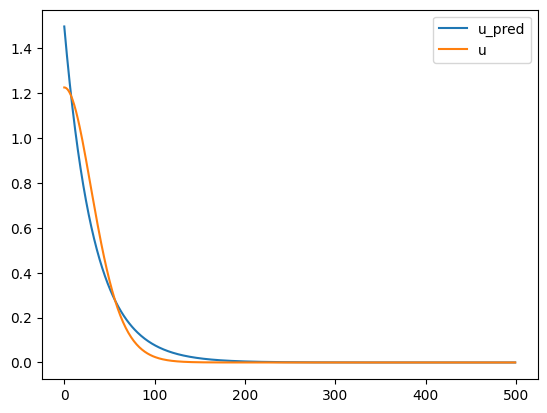

epoch 431 / 500 : loss = 131.47305297851562
epoch 432 / 500 : loss = 131.45635986328125
epoch 433 / 500 : loss = 131.43980407714844
epoch 434 / 500 : loss = 131.4234161376953


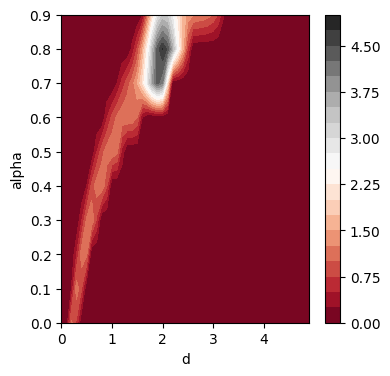

epoch 435 / 500 : loss = 131.4071807861328


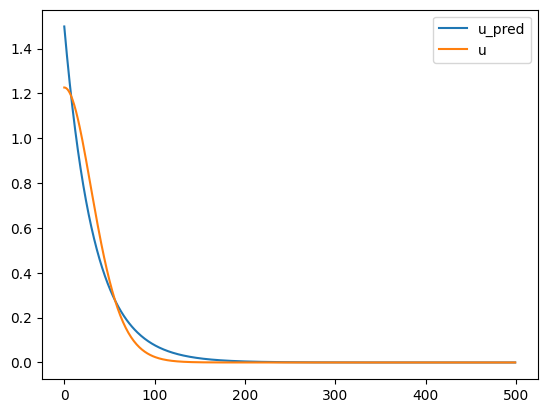

epoch 436 / 500 : loss = 131.39108276367188
epoch 437 / 500 : loss = 131.37506103515625
epoch 438 / 500 : loss = 131.35911560058594
epoch 439 / 500 : loss = 131.34327697753906


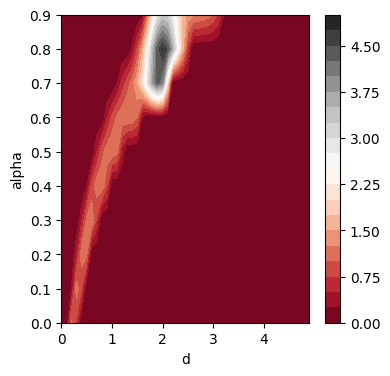

epoch 440 / 500 : loss = 131.32757568359375


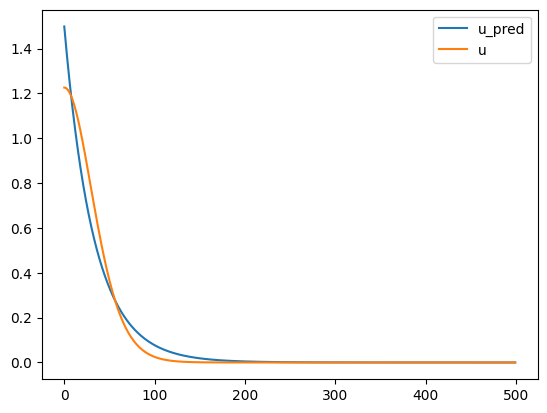

epoch 441 / 500 : loss = 131.31192016601562
epoch 442 / 500 : loss = 131.29635620117188
epoch 443 / 500 : loss = 131.2809295654297
epoch 444 / 500 : loss = 131.26556396484375


epoch 445 / 500 : loss = 131.25033569335938


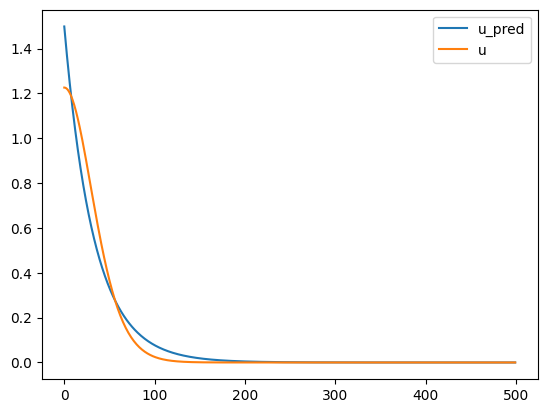

epoch 446 / 500 : loss = 131.23512268066406
epoch 447 / 500 : loss = 131.219970703125
epoch 448 / 500 : loss = 131.2048797607422
epoch 449 / 500 : loss = 131.18988037109375


epoch 450 / 500 : loss = 131.1749267578125


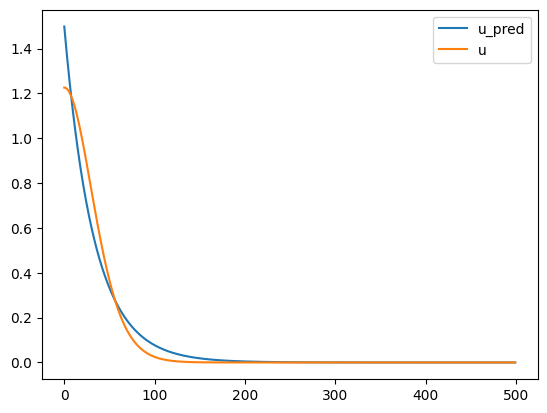

epoch 451 / 500 : loss = 131.16001892089844
epoch 452 / 500 : loss = 131.14532470703125
epoch 453 / 500 : loss = 131.13070678710938
epoch 454 / 500 : loss = 131.11618041992188


epoch 455 / 500 : loss = 131.10174560546875


epoch 456 / 500 : loss = 131.08741760253906
epoch 457 / 500 : loss = 131.07321166992188
epoch 458 / 500 : loss = 131.05914306640625
epoch 459 / 500 : loss = 131.045166015625


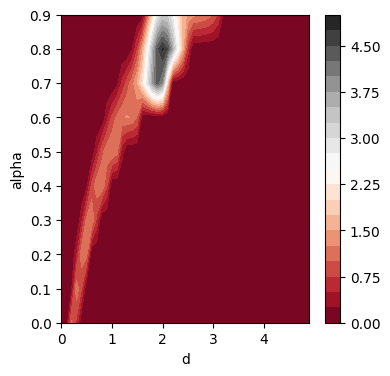

epoch 460 / 500 : loss = 131.03128051757812


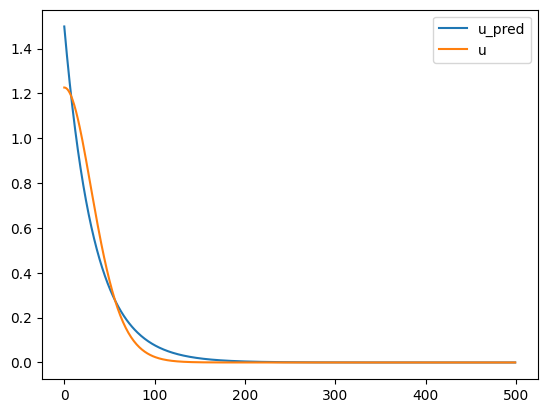

epoch 461 / 500 : loss = 131.0174560546875
epoch 462 / 500 : loss = 131.0037078857422
epoch 463 / 500 : loss = 130.99008178710938
epoch 464 / 500 : loss = 130.97662353515625


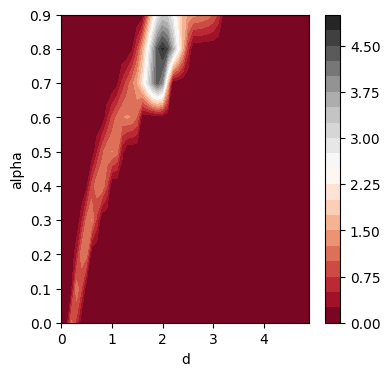

epoch 465 / 500 : loss = 130.96331787109375


epoch 466 / 500 : loss = 130.95005798339844
epoch 467 / 500 : loss = 130.93692016601562
epoch 468 / 500 : loss = 130.92384338378906
epoch 469 / 500 : loss = 130.91078186035156


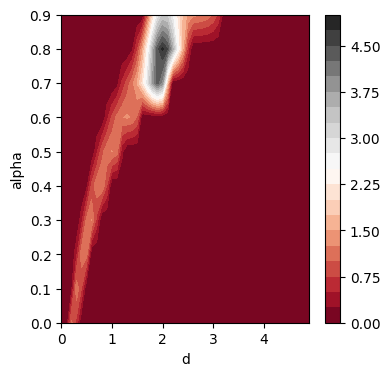

epoch 470 / 500 : loss = 130.89773559570312


epoch 471 / 500 : loss = 130.884765625
epoch 472 / 500 : loss = 130.87188720703125
epoch 473 / 500 : loss = 130.8590850830078
epoch 474 / 500 : loss = 130.84634399414062


epoch 475 / 500 : loss = 130.8336181640625


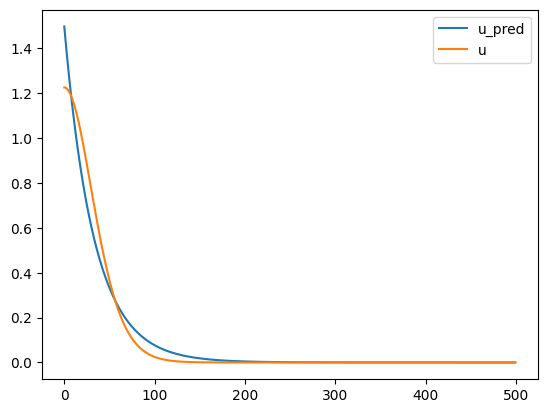

epoch 476 / 500 : loss = 130.82093811035156
epoch 477 / 500 : loss = 130.80836486816406
epoch 478 / 500 : loss = 130.79592895507812
epoch 479 / 500 : loss = 130.78353881835938


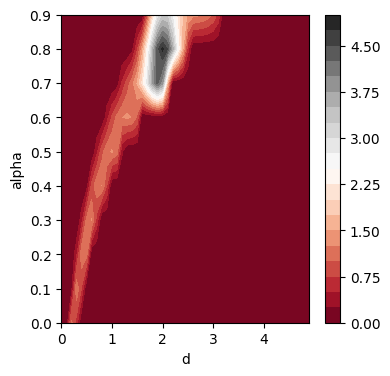

epoch 480 / 500 : loss = 130.77127075195312


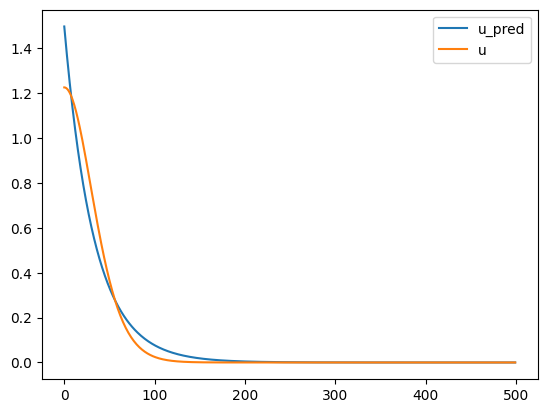

epoch 481 / 500 : loss = 130.75904846191406
epoch 482 / 500 : loss = 130.74691772460938
epoch 483 / 500 : loss = 130.73483276367188
epoch 484 / 500 : loss = 130.72279357910156


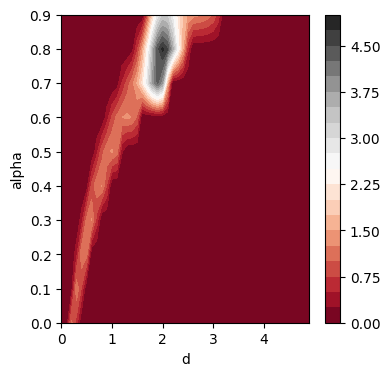

epoch 485 / 500 : loss = 130.7108154296875


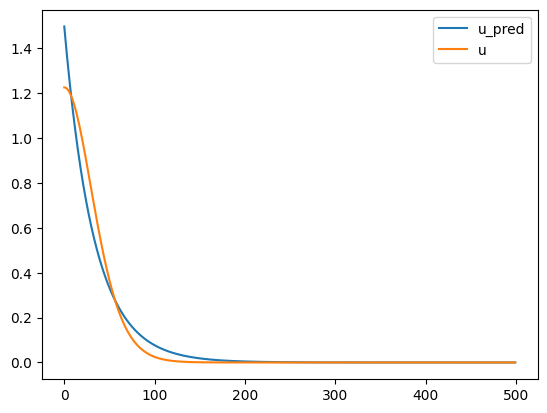

epoch 486 / 500 : loss = 130.69891357421875
epoch 487 / 500 : loss = 130.68714904785156
epoch 488 / 500 : loss = 130.67543029785156
epoch 489 / 500 : loss = 130.66380310058594


epoch 490 / 500 : loss = 130.65223693847656


epoch 491 / 500 : loss = 130.6407470703125
epoch 492 / 500 : loss = 130.6292724609375
epoch 493 / 500 : loss = 130.61785888671875
epoch 494 / 500 : loss = 130.6065216064453


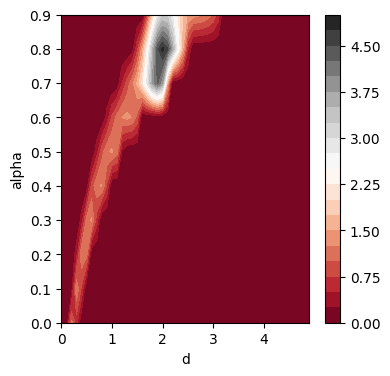

epoch 495 / 500 : loss = 130.5952606201172


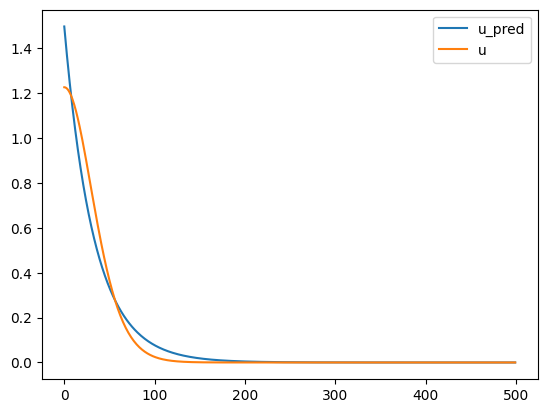

epoch 496 / 500 : loss = 130.5840606689453
epoch 497 / 500 : loss = 130.5729522705078
epoch 498 / 500 : loss = 130.5618438720703
epoch 499 / 500 : loss = 130.55075073242188


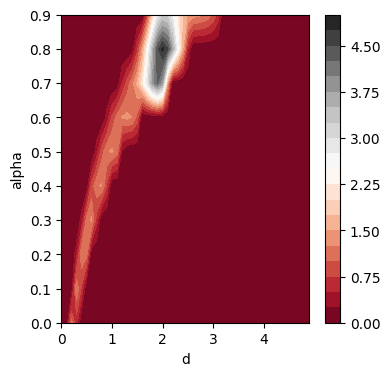

epoch 500 / 500 : loss = 130.53970336914062


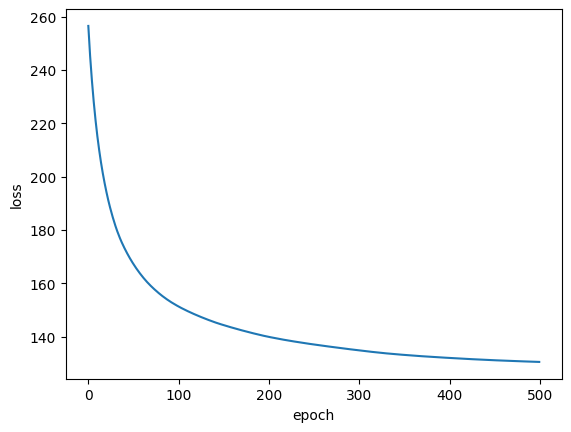

In [39]:
# train the model
P_alpha_d = train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=500, lr=1e-2)

In [40]:
P_alpha_d_cpu = P_alpha_d.cpu().detach().numpy()
# normalize P_alpha_d_cpu
# P_alpha_d_cpu = P_alpha_d_cpu / (P_alpha_d_cpu.sum(axis=(1,2), keepdims=True))
print(f"shape of P_alpha_d_cpu : {P_alpha_d_cpu.shape}")
# save P_alpha_d_cpu
np.save("P_alpha_d_cpu.npy", P_alpha_d_cpu)

shape of P_alpha_d_cpu : (100, 10, 50)


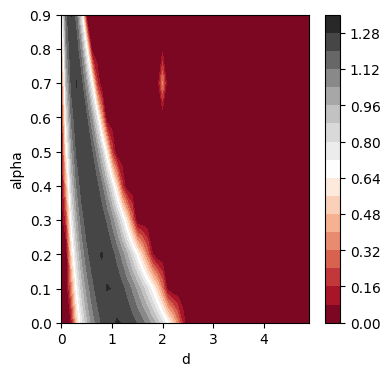

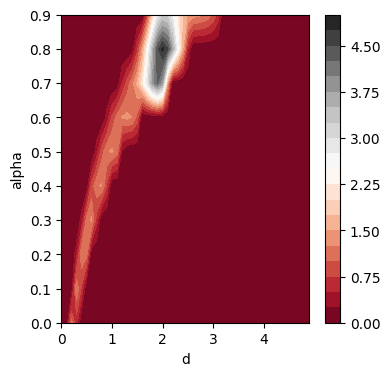

In [41]:
for i in range(0, s_vals.shape[0], 50):
    # copy P_alpha_d to cpu
    contour_plt(P_alpha_d_cpu, i)

In [42]:
# def give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals):
#     """
#     Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
#     """
#     # initialize u_pred
#     u_pred = np.zeros((s_vals.shape[0], len(r_vals)))

#     # convert P_alpha_d to numpy array
#     P_alpha_d = P_alpha_d.cpu().detach().numpy()
#     Z = Z.cpu().detach().numpy()
#     alpha_vals = alpha_vals.cpu().detach().numpy()
#     d_vals = d_vals.cpu().detach().numpy()

#     for i in range(u_pred.shape[0]):
#         for j in range(u_pred.shape[1]):
#             integrand = np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals, axis=1)
#             u_pred[i, j] = np.trapz(integrand, alpha_vals)

#     # normalize u_pred
#     u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True) + 1e-6)
#     # u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True))

#     # s_vals = np.linspace(0.0, 2*np.pi, 101)
#     s_vals = np.linspace(0.1, 20.1, 101)
#     # s_vals[0] = 1e-10
#     s_vals = s_vals[:-1]

#     # get the range of k values
#     # convert r_vals to numpy array
#     r_vals = r_vals.cpu().detach().numpy()
#     k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
#     k_vals = fft.fftshift(k_vals)
#     # k_vals = 2 * np.pi * k_vals
#     # print(k_vals)
#     print(f"shape of k_vals : {k_vals.shape}")

#     # visualize u_pred
#     plt.figure(figsize=(10, 8))
#     plt.title("u_pred(s, k) for some s values")
#     plt.xlabel("k")
#     plt.ylabel("u_pred(s, k)")
#     plt.grid()
#     for i in range(0, s_vals.shape[0], s_vals.shape[0]//10):
#         if i == 0:
#             continue
#         plt.plot(k_vals, u_pred[i, :], label=f"s = {s_vals[i]:.2f}")

#     plt.legend()
#     plt.show()

In [43]:
# reproduce u_pred
# give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals)
